<a href="https://colab.research.google.com/github/pratap977/CS6910/blob/main/Assignment-3/Attention(1-4)/RNN_WithoutAttention_Sweep%20and%20best%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dakshina Dataset from google


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from tensorflow.keras.utils import plot_model
from copy import copy
from math import log
import math


In [3]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

--2022-05-08 08:34:23--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 64.233.184.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   154MB/s    in 15s     

2022-05-08 08:34:39 (131 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [4]:
!tar -xvf '/content/dakshina_dataset_v1.0.tar'

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.nonblock.sections.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.omit_pages.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/na

Preprocess data

In [5]:
train_filename = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv'
validation_filename = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
test_filename = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

In [6]:
def processData(filename,input_chars=set(),target_chars=set()):
  input=[]
  target=[]
  with open(filename, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[:len(lines)-1]:
      t_text,i_text, attestation = line.split("\t")
       # We use "\t" as the "start sequence" character and "\n" as "end sequence" character for the target text.
      input.append(i_text)
      target.append("\t"+t_text+"\n")
      for char in i_text:
        if char not in input_chars:
            input_chars.add(char)
      for char in t_text:
        if char not in target_chars:
            target_chars.add(char)
  target_chars.add("\t")
  target_chars.add("\n")
  input_chars = sorted(list(input_chars))
  target_chars = sorted(list(target_chars))
  num_encoder_tokens = len(input_chars)
  num_decoder_tokens = len(target_chars)
  max_encoder_seq_length = max([len(txt) for txt in input])
  max_decoder_seq_length = max([len(txt) for txt in target])
  return input,target,input_chars,target_chars,num_encoder_tokens,num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length     

Preprocessing of Training Data

In [7]:
# Vectorize the data.
input,target,input_chars,target_chars,num_encoder_tokens,num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length=processData(train_filename)
print("Number of samples:", len(input))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 44204
Number of unique input tokens: 26
Number of unique output tokens: 65
Max sequence length for inputs: 20
Max sequence length for outputs: 21


Preprocessin of Validation Data

In [8]:
# Vectorize the data.
# Vectorize the data.
validation_input,validation_target,input_chars,target_chars,num_encoder_tokens,num_decoder_tokens, validation_max_encoder_seq_length, validation_max_decoder_seq_length=processData(validation_filename,set(input_chars),set(target_chars))

print("Number of validation samples:", len(validation_input))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("validation Max sequence length for inputs:", validation_max_encoder_seq_length)
print("validation Max sequence length for outputs:", validation_max_decoder_seq_length)

Number of validation samples: 4358
Number of unique input tokens: 26
Number of unique output tokens: 65
validation Max sequence length for inputs: 18
validation Max sequence length for outputs: 16


Preprocessing of Test Data

In [9]:
# Vectorize the data.
test_input,test_target,test_input_chars,test_target_chars,test_num_encoder_tokens,test_num_decoder_tokens, test_max_encoder_seq_length, test_max_decoder_seq_length=processData(test_filename)
print("Number of validation samples:", len(test_input))
print("Test Max sequence length for inputs:", test_max_encoder_seq_length)
print("Test Max sequence length for outputs:", test_max_decoder_seq_length)

Number of validation samples: 4502
Test Max sequence length for inputs: 16
Test Max sequence length for outputs: 17


In [10]:
input_token = dict([(char, i) for i, char in enumerate(input_chars)])
target_token = dict([(char, i) for i, char in enumerate(target_chars)])

reverse_input_token = dict((i, char) for char, i in input_token.items())
reverse_target_token = dict((i, char) for char, i in target_token.items())


encoder_input_data = np.zeros(
    (len(input), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
validation_encoder_input_data=np.zeros(
    (len(validation_input), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
test_encoder_input_data=np.zeros(
    (len(test_input), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
validation_decoder_input_data =np.zeros(
    (len(validation_input), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
validation_decoder_target_data = np.zeros(
    (len(validation_input), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input, target)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token[char]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token[char]] = 1.0
# for validation data
for i, (validation_input_text, validation_target_text) in enumerate(zip(validation_input, validation_target)):
    for t, char in enumerate(validation_input_text):
        validation_encoder_input_data[i, t, input_token[char]] = 1.0
    for t, char in enumerate(validation_target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        validation_decoder_input_data[i, t, target_token[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            validation_decoder_target_data[i, t - 1, target_token[char]] = 1.0

# for test data
for i, (test_input_text, test_target_text) in enumerate(zip(test_input, test_target)):
    for t, char in enumerate(test_input_text):
        test_encoder_input_data[i, t, input_token[char]] = 1.0

In [23]:
def beam_search_decoder(data, k):
    decodedWords = [[list(), 0.0]]
    # walk over each step in sequence
    for word in data:
      candidates = list()
      # expand each current candidate
      for sequence in decodedWords:
        seq, score = sequence
        for j in range(len(word)):
          candidate = [seq + [j], score - log(word[j])]
          candidates.append(candidate)
      # order all candidates by score
      ordered = sorted(candidates, key=lambda a:a[1])
      # select k best
      decodedWords = ordered[:k]
    return decodedWords
  
def translate(seq):
  sentence = [] 
  for x in seq:
    char = reverse_target_token[x]
    sentence.append(char)
  return "".join(sentence)





In [14]:
class WordAccuracyCallback(keras.callbacks.Callback):
  def __init__(self,beam_size):
    self.beam_size=beam_size
  def on_epoch_end(self, epoch, logs=None):
    pred=self.model.predict([validation_encoder_input_data,validation_decoder_input_data])
    count=0
    for i in range(pred.shape[0]):
      pSequences=beam_search_decoder(pred[i],self.beam_size)
      for j in range(self.beam_size):
        if "\t"+translate(pSequences[j][0][:len(validation_target[i])-1])==validation_target[i]:
          count=count+1
          break
    factor = 10.0 ** 4
    logs["WordAccuracy"]=math.trunc((count/pred.shape[0])*factor)/factor
    print("- wordAccuracy:",logs["WordAccuracy"])

In [24]:
class seq2seq_Model:

  def __init__(self,no_of_encoder_layers,no_of_decoder_layers,latent_dimension,dropout,recurrent_dropout,cell_type,beam_size):
    
    self.model = None
    self.encoder_inputs= None
    self.encoder_states = None
    self.decoder_inputs = None
    self.output_layers = []
    self.decoder_dense = None
    self.no_of_encoder_layers = no_of_encoder_layers
    self.no_of_decoder_layers = no_of_decoder_layers
    self.latent_dimension = latent_dimension
    self.dropout = dropout
    self.recurrent_dropout=recurrent_dropout
    self.cell_type=cell_type
    self.beam_size = beam_size
    self.encoder_model=None
    self.decoder_model=None

#this function builds and fits the model 
  def BUILD_FIT_MODEL(self,encoder_input_data,decoder_input_data ,decoder_target_data,epochs ,batch_size,validation_encoder_input_data,validation_decoder_input_data,validation_decoder_target_data,num_encoder_tokens,num_decoder_tokens):
    self.encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
    outputs = self.encoder_inputs
    self.encoder_states = []

    #initially we accumulter the outputs from the encoders and the states obtained
    for j in range(self.no_of_encoder_layers)[::-1]:
      if self.cell_type == "LSTM":
        outputs, state_h , state_c = keras.layers.LSTM(self.latent_dimension*(2**(self.no_of_encoder_layers-j-1)), return_state=True, return_sequences=bool(j),dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)(outputs)
        self.encoder_states += [ state_h , state_c]
      elif self.cell_type == "GRU" :
        outputs, state_h = keras.layers.GRU(self.latent_dimension*(2**(self.no_of_encoder_layers-j-1)), return_state=True, return_sequences=bool(j),dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)(outputs)
        self.encoder_states += [state_h]
      elif self.cell_type == "RNN" :
        outputs, state_h = keras.layers.SimpleRNN(self.latent_dimension*(2**(self.no_of_encoder_layers-j-1)), return_state=True, return_sequences=bool(j),dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)(outputs)
        self.encoder_states += [state_h]
    
    self.decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
    outputs = self.decoder_inputs
    #here we save the layers of decoder for fututere use but at the same time we go on to get the final output  
    for j in range(self.no_of_decoder_layers):

      # at each layer we are giving the dimensions as latent_dimension*2**(layer_number-1)
        if self.cell_type == "LSTM":
          self.output_layers.append(
              keras.layers.LSTM(self.latent_dimension*(2**(j)), return_sequences=True, return_state=True,dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)
          )
          outputs, dh, dc = self.output_layers[-1](outputs, initial_state=self.encoder_states[2*j:2*(j+1)])
        elif self.cell_type == "GRU" : 
          self.output_layers.append(
              keras.layers.GRU(self.latent_dimension*(2**(j)), return_sequences=True, return_state=True,dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)
          )
          outputs, dh = self.output_layers[-1](outputs, initial_state=self.encoder_states[j:j+1])
        elif self.cell_type == "RNN" : 
          self.output_layers.append(
              keras.layers.SimpleRNN(self.latent_dimension*(2**(j)), return_sequences=True, return_state=True,dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)
          )
          outputs, dh = self.output_layers[-1](outputs, initial_state=self.encoder_states[j:j+1])

 
    self.decoder_dense = keras.layers.Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = self.decoder_dense(outputs)
    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    self.model = keras.Model([self.encoder_inputs, self.decoder_inputs], decoder_outputs)
    self.model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy']) 
    self.model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks = [WordAccuracyCallback(self.beam_size)],verbose=1)
        # callbacks = [WordAccuracyCallback(self.beam_size),WandbCallback(monitor='WordAccuracy',
        #                                             save_model = True)],verbose=1)
    return 

  def load_model(self):
    encoder_model = keras.Model(self.encoder_inputs, self.encoder_states)
    d_output = self.decoder_inputs
    decoder_s_inputs = []
    decoder_states = []
    for j in range(self.no_of_decoder_layers):
        if self.cell_type =="LSTM":
          current_inputs = [keras.Input(shape=(self.latent_dimension*(2**(j)),)) for _ in range(2)]
        else :
          current_inputs = [keras.Input(shape=(self.latent_dimension*(2**(j)),))]

        out = self.output_layers[j](d_output, initial_state=current_inputs)

        d_output, cur_states = out[0], out[1:]

        decoder_states += cur_states
        decoder_s_inputs += current_inputs

    outputs = self.decoder_dense(d_output)
    decoder_model = keras.Model(
        [self.decoder_inputs] + decoder_s_inputs,
        [outputs] + decoder_states)
    self.encoder_model=encoder_model
    self.decoder_model=decoder_model
  def decode_sequence_using_inference(self,input_seq):
    # Encode the input as state vectors.
    states_values = self.encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token['\t']] = 1.


    decoded_sentence = []  
    while True:
        to_split = self.decoder_model.predict([target_seq] + states_values)

        output_token, states_values = to_split[0], to_split[1:]

        # Sample a token
        token_index = np.argmax(output_token[0, 0])
        char = reverse_target_token[token_index]
        decoded_sentence.append(char)

        # Exit condition: either hit max length
        # or find stop character.
        if char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            break

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, token_index] = 1.

    return "".join(decoded_sentence)
  def get_predictions(self,ip_data,op_text):
    n=len(ip_data)
    predictions = []
    num_correct = 0
    for i in range(n):
      input_seq = ip_data[i:i+1]
      decoded_seq = self.decode_sequence_using_inference(input_seq)
      if decoded_seq[-1]=='\n':
        decoded_seq = decoded_seq[:-1]

      predictions+=[decoded_seq]
      #excluding the '\t and \n'
      true_word = op_text[i][1:-1]
      #getting word level accuracy...
      num_correct+=(decoded_seq == true_word)

    acc = num_correct/n
    return (acc,predictions)


In [16]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 33.5 MB/s 
     |████████████████████████████████| 181 kB 72.7 MB/s 
     |████████████████████████████████| 144 kB 74.6 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
import wandb
from wandb.keras import WandbCallback

In [18]:
sweep_config = {
  'name': 'RNN',
  'method': 'bayes',
  'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
  'parameters': {
        'encoder_layers':{
            'values':[1,2,3]
        },
        'decoder_layers':{
            'values':[1,2,3]
        },
        'hidden_layer_size':{
            'values':[64,128,256]
        },
        'cell_type':{
            'values':['GRU', 'LSTM','RNN']
        },
        'dropout':{
            'values':[0.0,0.3]
        },
        'recurrent_dropout':{
            'values':[0.0,0.3]
        },
        'beam_size':{
            'values':[1,3,5]
        }

    }
}

sweep_id = wandb.sweep(sweep_config, project='RNN_Assignment',entity="pratap49")

Create sweep with ID: 6ecyv1mn
Sweep URL: https://wandb.ai/pratap49/RNN_Assignment/sweeps/6ecyv1mn


In [ ]:
def train():
  run = wandb.init()
  configuration=run.config
  if configuration.encoder_layers >= configuration.decoder_layers:
    seq2seq = seq2seq_Model(no_of_encoder_layers=configuration.encoder_layers,no_of_decoder_layers=configuration.decoder_layers,
                    latent_dimension=configuration.hidden_layer_size,dropout=configuration.dropout,recurrent_dropout=configuration.recurrent_dropout,cell_type=configuration.cell_type,beam_size=configuration.beam_size)
    seq2seq.BUILD_FIT_MODEL( encoder_input_data,decoder_input_data,  decoder_target_data,10,64,
      validation_encoder_input_data , validation_decoder_input_data, validation_decoder_target_data,num_encoder_tokens,num_decoder_tokens)
sweep_id="pwdj5rdt"
wandb.agent(sweep_id=sweep_id, function=train)

wandb: Agent Starting Run: wevmvzgt with config:
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 1
wandb: 	dropout: 0
wandb: 	encoder_layers: 1
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3
wandb: Currently logged in as: pratap49. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
691/691 [==============================] - 113s 155ms/step - loss: 1.0982 - accuracy: 0.0798 - WordAccuracy: 4.0000e-04 - _timestamp: 1651906168.0000 - _runtime: 125.0000
Epoch 2/10
691/691 [==============================] - 104s 151ms/step - loss: 0.9921 - accuracy: 0.1021 - WordAccuracy: 0.0011 - _timestamp: 1651906273.0000 - _runtime: 230.0000
Epoch 3/10
691/691 [==============================] - 105s 152ms/step - loss: 0.8991 - accuracy: 0.1200 - WordAccuracy: 0.0011 - _timestamp: 1651906378.0000 - _runtime: 335.0000
Epoch 4/10
691/691 [==============================] - 104s 151ms/step - loss: 0.8041 - accuracy: 0.1349 - WordAccuracy: 0.0020 - _timestamp: 1651906482.0000 - _runtime: 439.0000
Epoch 5/10
691/691 [==============================] - 105s 151ms/step - loss: 0.7349 - accuracy: 0.1495 - WordAccuracy: 0.0096 - _timestamp: 1651906587.0000 - _runtime: 544.0000
Epoch 6/10
691/691 [==============================] - 104s 151ms/step - loss: 0.6765 - accuracy: 0.1639 - 

WordAccuracy,▁▁▁▁▁▂▃▄▇█
accuracy,▁▂▃▄▅▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▃▂▁▁
WordAccuracy,0.1422
accuracy,0.21188
best_WordAccuracy,0.0004
best_epoch,0
epoch,9
loss,0.48605


wandb: Agent Starting Run: z9mr77vu with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 128
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 220s 309ms/step - loss: 1.0538 - accuracy: 0.0924 - WordAccuracy: 0.0025 - _timestamp: 1651907343.0000 - _runtime: 226.0000
Epoch 2/10
691/691 [==============================] - 212s 306ms/step - loss: 0.8824 - accuracy: 0.1396 - WordAccuracy: 0.0066 - _timestamp: 1651907555.0000 - _runtime: 438.0000
Epoch 3/10
691/691 [==============================] - 213s 308ms/step - loss: 0.7193 - accuracy: 0.1652 - WordAccuracy: 0.0318 - _timestamp: 1651907768.0000 - _runtime: 651.0000
Epoch 4/10
691/691 [==============================] - 214s 309ms/step - loss: 0.6089 - accuracy: 0.1872 - WordAccuracy: 0.0557 - _timestamp: 1651907982.0000 - _runtime: 865.0000
Epoch 5/10
691/691 [==============================] - 211s 306ms/step - loss: 0.5368 - accuracy: 0.2049 - WordAccuracy: 0.1190 - _timestamp: 1651908193.0000 - _runtime: 1076.0000
Epoch 6/10
691/691 [==============================] - 212s 307ms/step - loss: 0.4793 - accuracy: 0.2204 - Wor

WordAccuracy,▁▁▂▂▄▅▆▇▇█
accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▂▁▁
WordAccuracy,0.2765
accuracy,0.25855
best_WordAccuracy,0.0025
best_epoch,0
epoch,9
loss,0.33341


wandb: Agent Starting Run: 0c5q0elr with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 1
wandb: 	dropout: 0
wandb: 	encoder_layers: 1
wandb: 	hidden_layer_size: 64
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 41s 58ms/step - loss: 1.1984 - accuracy: 0.0788 - WordAccuracy: 6.0000e-04 - _timestamp: 1651909308.0000 - _runtime: 47.0000
Epoch 2/10
691/691 [==============================] - 40s 58ms/step - loss: 1.0936 - accuracy: 0.1012 - WordAccuracy: 0.0011 - _timestamp: 1651909348.0000 - _runtime: 87.0000
Epoch 3/10
691/691 [==============================] - 40s 58ms/step - loss: 1.0431 - accuracy: 0.1131 - WordAccuracy: 4.0000e-04 - _timestamp: 1651909388.0000 - _runtime: 127.0000
Epoch 4/10
691/691 [==============================] - 40s 58ms/step - loss: 1.0095 - accuracy: 0.1196 - WordAccuracy: 0.0018 - _timestamp: 1651909428.0000 - _runtime: 167.0000
Epoch 5/10
691/691 [==============================] - 39s 57ms/step - loss: 0.9835 - accuracy: 0.1241 - WordAccuracy: 0.0013 - _timestamp: 1651909467.0000 - _runtime: 206.0000
Epoch 6/10
691/691 [==============================] - 40s 58ms/step - loss: 0.9626 - accuracy: 0.1275 - WordAccura

WordAccuracy,▂▃▁▅▄█▇▇▇▇
accuracy,▁▄▅▆▆▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▄▃▃▂▂▁▁
WordAccuracy,0.0027
accuracy,0.13702
best_WordAccuracy,0.0004
best_epoch,2
epoch,9
loss,0.89659


wandb: Agent Starting Run: fg3w6pnm with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 54s 64ms/step - loss: 0.9740 - accuracy: 0.1073 - WordAccuracy: 0.0020 - _timestamp: 1651909781.0000 - _runtime: 63.0000
Epoch 2/10
691/691 [==============================] - 43s 62ms/step - loss: 0.7887 - accuracy: 0.1507 - WordAccuracy: 0.0055 - _timestamp: 1651909824.0000 - _runtime: 106.0000
Epoch 3/10
691/691 [==============================] - 43s 63ms/step - loss: 0.6417 - accuracy: 0.1794 - WordAccuracy: 0.0211 - _timestamp: 1651909868.0000 - _runtime: 150.0000
Epoch 4/10
691/691 [==============================] - 44s 63ms/step - loss: 0.4343 - accuracy: 0.2210 - WordAccuracy: 0.0915 - _timestamp: 1651909912.0000 - _runtime: 194.0000
Epoch 5/10
691/691 [==============================] - 44s 64ms/step - loss: 0.2611 - accuracy: 0.2683 - WordAccuracy: 0.2425 - _timestamp: 1651909956.0000 - _runtime: 238.0000
Epoch 6/10
691/691 [==============================] - 44s 64ms/step - loss: 0.1736 - accuracy: 0.2944 - WordAccuracy: 0.2

WordAccuracy,▁▁▁▃▆▇████
accuracy,▁▂▃▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▃▂▁▁▁▁
WordAccuracy,0.3455
accuracy,0.32822
best_WordAccuracy,0.002
best_epoch,0
epoch,9
loss,0.06195


wandb: Agent Starting Run: s64w7bll with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 2
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 2
wandb: 	hidden_layer_size: 128
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 212s 297ms/step - loss: 1.0779 - accuracy: 0.0841 - WordAccuracy: 4.0000e-04 - _timestamp: 1651910404.0000 - _runtime: 219.0000
Epoch 2/10
691/691 [==============================] - 201s 291ms/step - loss: 0.9188 - accuracy: 0.1151 - WordAccuracy: 0.0036 - _timestamp: 1651910605.0000 - _runtime: 420.0000
Epoch 3/10
691/691 [==============================] - 203s 293ms/step - loss: 0.8038 - accuracy: 0.1359 - WordAccuracy: 0.0075 - _timestamp: 1651910807.0000 - _runtime: 622.0000
Epoch 4/10
691/691 [==============================] - 201s 291ms/step - loss: 0.7320 - accuracy: 0.1510 - WordAccuracy: 0.0380 - _timestamp: 1651911009.0000 - _runtime: 824.0000
Epoch 5/10
691/691 [==============================] - 201s 290ms/step - loss: 0.6737 - accuracy: 0.1638 - WordAccuracy: 0.0692 - _timestamp: 1651911209.0000 - _runtime: 1024.0000
Epoch 6/10
691/691 [==============================] - 202s 292ms/step - loss: 0.6247 - accuracy: 0.1756 -

WordAccuracy,▁▁▁▂▃▅▆▇▇█
accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▂▁▁
WordAccuracy,0.1952
accuracy,0.20614
best_WordAccuracy,0.0004
best_epoch,0
epoch,9
loss,0.50587


wandb: Agent Starting Run: uypa4up3 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 64
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 29s 38ms/step - loss: 1.1855 - accuracy: 0.0720 - WordAccuracy: 4.0000e-04 - _timestamp: 1651912306.0000 - _runtime: 36.0000
Epoch 2/10
691/691 [==============================] - 25s 36ms/step - loss: 1.1209 - accuracy: 0.0910 - WordAccuracy: 0.0011 - _timestamp: 1651912331.0000 - _runtime: 61.0000
Epoch 3/10
691/691 [==============================] - 25s 36ms/step - loss: 1.0897 - accuracy: 0.1004 - WordAccuracy: 0.0022 - _timestamp: 1651912356.0000 - _runtime: 86.0000
Epoch 4/10
691/691 [==============================] - 25s 37ms/step - loss: 1.0707 - accuracy: 0.1062 - WordAccuracy: 0.0018 - _timestamp: 1651912381.0000 - _runtime: 111.0000
Epoch 5/10
691/691 [==============================] - 25s 36ms/step - loss: 1.0573 - accuracy: 0.1104 - WordAccuracy: 0.0020 - _timestamp: 1651912406.0000 - _runtime: 136.0000
Epoch 6/10
691/691 [==============================] - 25s 36ms/step - loss: 1.0454 - accuracy: 0.1137 - WordAccuracy: 0

WordAccuracy,▁▃▇▆▆▆▇▆██
accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
WordAccuracy,0.0025
accuracy,0.12248
best_WordAccuracy,0.0004
best_epoch,0
epoch,9
loss,1.01437


wandb: Agent Starting Run: dlc0zj6n with config:
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 1
wandb: 	dropout: 0
wandb: 	encoder_layers: 2
wandb: 	hidden_layer_size: 64
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 103s 144ms/step - loss: 1.1793 - accuracy: 0.0691 - WordAccuracy: 4.0000e-04 - _timestamp: 1651912649.0000 - _runtime: 109.0000
Epoch 2/10
691/691 [==============================] - 100s 145ms/step - loss: 1.0926 - accuracy: 0.0895 - WordAccuracy: 0.0000e+00 - _timestamp: 1651912749.0000 - _runtime: 209.0000
Epoch 3/10
691/691 [==============================] - 100s 144ms/step - loss: 1.0200 - accuracy: 0.1028 - WordAccuracy: 0.0000e+00 - _timestamp: 1651912849.0000 - _runtime: 309.0000
Epoch 4/10
691/691 [==============================] - 100s 145ms/step - loss: 0.9728 - accuracy: 0.1108 - WordAccuracy: 0.0000e+00 - _timestamp: 1651912949.0000 - _runtime: 409.0000
Epoch 5/10
568/691 [=======================>......] - ETA: 13s - loss: 0.9460 - accuracy: 0.1171

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


691/691 [==============================] - 100s 145ms/step - loss: 0.9448 - accuracy: 0.1175 - WordAccuracy: 0.0000e+00 - _timestamp: 1651913049.0000 - _runtime: 509.0000
Epoch 6/10
184/691 [======>.......................] - ETA: 56s - loss: 0.9250 - accuracy: 0.1194

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


691/691 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.1204

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.


- wordAccuracy: 0.0
691/691 [==============================] - 99s 143ms/step - loss: 0.9250 - accuracy: 0.1204 - WordAccuracy: 0.0000e+00 - _timestamp: 1651913148.0000 - _runtime: 608.0000
Epoch 7/10
691/691 [==============================] - 99s 144ms/step - loss: 0.9092 - accuracy: 0.1222 - WordAccuracy: 0.0000e+00 - _timestamp: 1651913248.0000 - _runtime: 708.0000
Epoch 8/10
691/691 [==============================] - 99s 143ms/step - loss: 0.8948 - accuracy: 0.1246 - WordAccuracy: 0.0000e+00 - _timestamp: 1651913346.0000 - _runtime: 806.0000
Epoch 9/10
691/691 [==============================] - 99s 144ms/step - loss: 0.8824 - accuracy: 0.1263 - WordAccuracy: 0.0000e+00 - _timestamp: 1651913446.0000 - _runtime: 906.0000
Epoch 10/10
691/691 [==============================] - 100s 144ms/step - loss: 0.8723 - accuracy: 0.1278 - WordAccuracy: 0.0000e+00 - _timestamp: 1651913545.0000 - _runtime: 1005.0000


WordAccuracy,█▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▂▁▁
WordAccuracy,0.0
accuracy,0.12779
best_WordAccuracy,0.0004
best_epoch,0
epoch,9
loss,0.87225


wandb: Agent Starting Run: dqed7zzj with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 1
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 117s 163ms/step - loss: 1.0883 - accuracy: 0.0866 - WordAccuracy: 0.0018 - _timestamp: 1651913727.0000 - _runtime: 124.0000
Epoch 2/10
691/691 [==============================] - 113s 163ms/step - loss: 0.9416 - accuracy: 0.1253 - WordAccuracy: 0.0045 - _timestamp: 1651913839.0000 - _runtime: 236.0000
Epoch 3/10
691/691 [==============================] - 112s 162ms/step - loss: 0.8598 - accuracy: 0.1484 - WordAccuracy: 0.0055 - _timestamp: 1651913951.0000 - _runtime: 348.0000
Epoch 4/10
691/691 [==============================] - 113s 163ms/step - loss: 0.7999 - accuracy: 0.1640 - WordAccuracy: 0.0110 - _timestamp: 1651914064.0000 - _runtime: 461.0000
Epoch 5/10
691/691 [==============================] - 113s 163ms/step - loss: 0.7596 - accuracy: 0.1750 - WordAccuracy: 0.0165 - _timestamp: 1651914177.0000 - _runtime: 574.0000
Epoch 6/10
691/691 [==============================] - 113s 163ms/step - loss: 0.7286 - accuracy: 0.1837 - Word

WordAccuracy,▁▁▂▂▃▄▃▄█▄
accuracy,▁▃▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
WordAccuracy,0.0231
accuracy,0.20177
best_WordAccuracy,0.0018
best_epoch,0
epoch,9
loss,0.66092


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8em5ls3z with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 51s 64ms/step - loss: 1.0445 - accuracy: 0.0917 - WordAccuracy: 2.0000e-04 - _timestamp: 1651914814.0000 - _runtime: 60.0000
Epoch 2/10
691/691 [==============================] - 43s 62ms/step - loss: 0.8655 - accuracy: 0.1355 - WordAccuracy: 0.0039 - _timestamp: 1651914857.0000 - _runtime: 103.0000
Epoch 3/10
691/691 [==============================] - 43s 63ms/step - loss: 0.7644 - accuracy: 0.1578 - WordAccuracy: 0.0087 - _timestamp: 1651914901.0000 - _runtime: 147.0000
Epoch 4/10
691/691 [==============================] - 43s 62ms/step - loss: 0.5531 - accuracy: 0.1951 - WordAccuracy: 0.0518 - _timestamp: 1651914944.0000 - _runtime: 190.0000
Epoch 5/10
691/691 [==============================] - 44s 64ms/step - loss: 0.3335 - accuracy: 0.2471 - WordAccuracy: 0.1693 - _timestamp: 1651914988.0000 - _runtime: 234.0000
Epoch 6/10
691/691 [==============================] - 44s 63ms/step - loss: 0.2082 - accuracy: 0.2832 - WordAccuracy:

WordAccuracy,▁▁▁▂▄▅▇▇██
accuracy,▁▂▃▄▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▄▃▂▂▁▁▁
WordAccuracy,0.3568
accuracy,0.32565
best_WordAccuracy,0.0002
best_epoch,0
epoch,9
loss,0.06941


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j7wjg7qz with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 392s 551ms/step - loss: 1.0451 - accuracy: 0.0910 - WordAccuracy: 9.0000e-04 - _timestamp: 1651915630.0000 - _runtime: 401.0000
Epoch 2/10
691/691 [==============================] - 380s 549ms/step - loss: 0.9459 - accuracy: 0.1134 - WordAccuracy: 0.0052 - _timestamp: 1651916010.0000 - _runtime: 781.0000
Epoch 3/10
691/691 [==============================] - 382s 553ms/step - loss: 0.8901 - accuracy: 0.1269 - WordAccuracy: 0.0061 - _timestamp: 1651916393.0000 - _runtime: 1164.0000
Epoch 4/10
691/691 [==============================] - 384s 555ms/step - loss: 0.7644 - accuracy: 0.1483 - WordAccuracy: 0.0188 - _timestamp: 1651916776.0000 - _runtime: 1547.0000
Epoch 5/10
691/691 [==============================] - 378s 547ms/step - loss: 0.6520 - accuracy: 0.1697 - WordAccuracy: 0.0497 - _timestamp: 1651917154.0000 - _runtime: 1925.0000
Epoch 6/10
691/691 [==============================] - 380s 550ms/step - loss: 0.5451 - accuracy: 0.1931

WordAccuracy,▁▁▁▁▂▄▅███
accuracy,▁▂▂▃▄▅▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▅▄▃▃▂▁▁
WordAccuracy,0.3327
accuracy,0.26012
best_WordAccuracy,0.0009
best_epoch,0
epoch,9
loss,0.29013


wandb: Agent Starting Run: q6k2y1n5 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 128
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 63s 87ms/step - loss: 0.8062 - accuracy: 0.1551 - WordAccuracy: 0.0339 - _timestamp: 1651919191.0000 - _runtime: 70.0000
Epoch 2/10
691/691 [==============================] - 60s 87ms/step - loss: 0.4986 - accuracy: 0.2095 - WordAccuracy: 0.1124 - _timestamp: 1651919251.0000 - _runtime: 130.0000
Epoch 3/10
691/691 [==============================] - 60s 87ms/step - loss: 0.4093 - accuracy: 0.2307 - WordAccuracy: 0.1668 - _timestamp: 1651919311.0000 - _runtime: 190.0000
Epoch 4/10
691/691 [==============================] - 59s 86ms/step - loss: 0.3669 - accuracy: 0.2414 - WordAccuracy: 0.1443 - _timestamp: 1651919370.0000 - _runtime: 249.0000
Epoch 5/10
691/691 [==============================] - 59s 86ms/step - loss: 0.3411 - accuracy: 0.2484 - WordAccuracy: 0.1704 - _timestamp: 1651919429.0000 - _runtime: 308.0000
Epoch 6/10
691/691 [==============================] - 59s 86ms/step - loss: 0.3222 - accuracy: 0.2534 - WordAccuracy: 0.1

WordAccuracy,▁▅█▆█▇▇█▇▇
accuracy,▁▄▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
WordAccuracy,0.1569
accuracy,0.265
best_WordAccuracy,0.0339
best_epoch,0
epoch,9
loss,0.28006


wandb: Agent Starting Run: bun8exq8 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 2
wandb: 	hidden_layer_size: 64
wandb: 	recurrent_dropout: 0


wandb: Agent Starting Run: fw7b0sej with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 346s 487ms/step - loss: 0.9790 - accuracy: 0.1053 - WordAccuracy: 0.0039 - _timestamp: 1651920139.0000 - _runtime: 357.0000
Epoch 2/10
691/691 [==============================] - 335s 484ms/step - loss: 0.8072 - accuracy: 0.1476 - WordAccuracy: 0.0144 - _timestamp: 1651920474.0000 - _runtime: 692.0000
Epoch 3/10
691/691 [==============================] - 338s 488ms/step - loss: 0.6125 - accuracy: 0.1820 - WordAccuracy: 0.0516 - _timestamp: 1651920812.0000 - _runtime: 1030.0000
Epoch 4/10
691/691 [==============================] - 337s 488ms/step - loss: 0.4034 - accuracy: 0.2292 - WordAccuracy: 0.2147 - _timestamp: 1651921149.0000 - _runtime: 1367.0000
Epoch 5/10
691/691 [==============================] - 338s 490ms/step - loss: 0.2603 - accuracy: 0.2679 - WordAccuracy: 0.3095 - _timestamp: 1651921487.0000 - _runtime: 1705.0000
Epoch 6/10
691/691 [==============================] - 338s 490ms/step - loss: 0.1893 - accuracy: 0.2888 - W

WordAccuracy,▁▁▂▅▆▆▇▇▇█
accuracy,▁▂▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▃▂▂▁▁▁▁
WordAccuracy,0.4164
accuracy,0.31824
best_WordAccuracy,0.0039
best_epoch,0
epoch,9
loss,0.09239


wandb: Agent Starting Run: fyq0urh1 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 119s 165ms/step - loss: 1.1595 - accuracy: 0.0604 - WordAccuracy: 0.0000e+00 - _timestamp: 1651923322.0000 - _runtime: 126.0000
Epoch 2/10
691/691 [==============================] - 114s 165ms/step - loss: 1.1382 - accuracy: 0.0652 - WordAccuracy: 0.0000e+00 - _timestamp: 1651923436.0000 - _runtime: 240.0000
Epoch 3/10
691/691 [==============================] - 115s 166ms/step - loss: 1.1372 - accuracy: 0.0646 - WordAccuracy: 0.0000e+00 - _timestamp: 1651923551.0000 - _runtime: 355.0000
Epoch 4/10
691/691 [==============================] - 114s 165ms/step - loss: 1.0812 - accuracy: 0.0773 - WordAccuracy: 4.0000e-04 - _timestamp: 1651923665.0000 - _runtime: 469.0000
Epoch 5/10
691/691 [==============================] - 113s 164ms/step - loss: 0.9627 - accuracy: 0.0900 - WordAccuracy: 0.0000e+00 - _timestamp: 1651923778.0000 - _runtime: 582.0000
Epoch 6/10
691/691 [==============================] - 115s 167ms/step - loss: 0.9141 - acc

WordAccuracy,▁▁▁█▁▁▁▁▁▁
accuracy,▁▂▂▃▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,███▆▄▃▂▁▁▁
WordAccuracy,0.0
accuracy,0.11199
best_WordAccuracy,0.0004
best_epoch,3
epoch,9
loss,0.84581


wandb: Agent Starting Run: v3isg1pk with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 398s 558ms/step - loss: 1.0385 - accuracy: 0.0920 - WordAccuracy: 0.0032 - _timestamp: 1651924772.0000 - _runtime: 409.0000
Epoch 2/10
691/691 [==============================] - 384s 555ms/step - loss: 0.9350 - accuracy: 0.1159 - WordAccuracy: 0.0018 - _timestamp: 1651925156.0000 - _runtime: 793.0000
Epoch 3/10
691/691 [==============================] - 384s 555ms/step - loss: 0.8834 - accuracy: 0.1272 - WordAccuracy: 0.0068 - _timestamp: 1651925540.0000 - _runtime: 1177.0000
Epoch 4/10
691/691 [==============================] - 381s 552ms/step - loss: 0.8150 - accuracy: 0.1435 - WordAccuracy: 0.0128 - _timestamp: 1651925922.0000 - _runtime: 1559.0000
Epoch 5/10
511/691 [=====================>........] - ETA: 1:34 - loss: 0.6929 - accuracy: 0.1627

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


691/691 [==============================] - 383s 555ms/step - loss: 0.6762 - accuracy: 0.1658 - WordAccuracy: 0.0456 - _timestamp: 1651926305.0000 - _runtime: 1942.0000
Epoch 6/10
691/691 [==============================] - 385s 557ms/step - loss: 0.5513 - accuracy: 0.1906 - WordAccuracy: 0.1030 - _timestamp: 1651926690.0000 - _runtime: 2327.0000
Epoch 7/10
691/691 [==============================] - 383s 555ms/step - loss: 0.4509 - accuracy: 0.2150 - WordAccuracy: 0.1782 - _timestamp: 1651927073.0000 - _runtime: 2710.0000
Epoch 8/10
691/691 [==============================] - 383s 554ms/step - loss: 0.3784 - accuracy: 0.2344 - WordAccuracy: 0.2829 - _timestamp: 1651927456.0000 - _runtime: 3093.0000
Epoch 9/10
691/691 [==============================] - 385s 556ms/step - loss: 0.3248 - accuracy: 0.2497 - WordAccuracy: 0.3451 - _timestamp: 1651927841.0000 - _runtime: 3478.0000
Epoch 10/10
691/691 [==============================] - 383s 554ms/step - loss: 0.2869 - accuracy: 0.2609 - WordAccur

WordAccuracy,▁▁▁▁▂▃▄▇██
accuracy,▁▂▂▃▄▅▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▃▃▂▁▁
WordAccuracy,0.3558
accuracy,0.26087
best_WordAccuracy,0.0018
best_epoch,1
epoch,9
loss,0.28693


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8oe7nxvp with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 2
wandb: 	hidden_layer_size: 64
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 13s 15ms/step - loss: 1.1836 - accuracy: 0.0714 - WordAccuracy: 0.0000e+00 - _timestamp: 1651928267.0000 - _runtime: 21.0000
Epoch 2/10
691/691 [==============================] - 10s 15ms/step - loss: 1.1187 - accuracy: 0.0896 - WordAccuracy: 4.0000e-04 - _timestamp: 1651928277.0000 - _runtime: 31.0000
Epoch 3/10
691/691 [==============================] - 10s 14ms/step - loss: 1.0893 - accuracy: 0.0995 - WordAccuracy: 4.0000e-04 - _timestamp: 1651928287.0000 - _runtime: 41.0000
Epoch 4/10
691/691 [==============================] - 10s 14ms/step - loss: 1.0688 - accuracy: 0.1060 - WordAccuracy: 0.0011 - _timestamp: 1651928297.0000 - _runtime: 51.0000
Epoch 5/10
691/691 [==============================] - 10s 14ms/step - loss: 1.0539 - accuracy: 0.1104 - WordAccuracy: 4.0000e-04 - _timestamp: 1651928307.0000 - _runtime: 61.0000
Epoch 6/10
691/691 [==============================] - 10s 14ms/step - loss: 1.0408 - accuracy: 0.1142 - WordA

WordAccuracy,▁▄▄█▄▅▄▂▅▇
accuracy,▁▃▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
WordAccuracy,0.0009
accuracy,0.12399
best_WordAccuracy,0.0002
best_epoch,7
epoch,9
loss,1.00684


wandb: Agent Starting Run: ywqsvtdm with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 350s 490ms/step - loss: 1.0299 - accuracy: 0.0920 - WordAccuracy: 0.0139 - _timestamp: 1651928771.0000 - _runtime: 361.0000
Epoch 2/10
691/691 [==============================] - 334s 483ms/step - loss: 0.7215 - accuracy: 0.1514 - WordAccuracy: 0.0858 - _timestamp: 1651929104.0000 - _runtime: 694.0000
Epoch 3/10
691/691 [==============================] - 337s 488ms/step - loss: 0.5578 - accuracy: 0.1897 - WordAccuracy: 0.2260 - _timestamp: 1651929442.0000 - _runtime: 1032.0000
Epoch 4/10
691/691 [==============================] - 336s 487ms/step - loss: 0.4262 - accuracy: 0.2239 - WordAccuracy: 0.3001 - _timestamp: 1651929778.0000 - _runtime: 1368.0000
Epoch 5/10
691/691 [==============================] - 337s 488ms/step - loss: 0.3494 - accuracy: 0.2452 - WordAccuracy: 0.3604 - _timestamp: 1651930115.0000 - _runtime: 1705.0000
Epoch 6/10
691/691 [==============================] - 337s 488ms/step - loss: 0.3028 - accuracy: 0.2583 - W

WordAccuracy,▁▂▅▆█▅█▇██
accuracy,▁▃▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▁▁▁▁
WordAccuracy,0.3758
accuracy,0.28065
best_WordAccuracy,0.0139
best_epoch,0
epoch,9
loss,0.22525


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hbw7i879 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 349s 490ms/step - loss: 1.0481 - accuracy: 0.0884 - WordAccuracy: 9.0000e-04 - _timestamp: 1651932191.0000 - _runtime: 358.0000
Epoch 2/10
691/691 [==============================] - 340s 492ms/step - loss: 0.8992 - accuracy: 0.1274 - WordAccuracy: 0.0064 - _timestamp: 1651932531.0000 - _runtime: 698.0000
Epoch 3/10
691/691 [==============================] - 340s 492ms/step - loss: 0.8834 - accuracy: 0.1309 - WordAccuracy: 0.0016 - _timestamp: 1651932871.0000 - _runtime: 1038.0000
Epoch 4/10
691/691 [==============================] - 340s 491ms/step - loss: 0.8569 - accuracy: 0.1380 - WordAccuracy: 0.0043 - _timestamp: 1651933210.0000 - _runtime: 1377.0000
Epoch 5/10
691/691 [==============================] - 339s 491ms/step - loss: 0.8811 - accuracy: 0.1318 - WordAccuracy: 0.0064 - _timestamp: 1651933549.0000 - _runtime: 1716.0000
Epoch 6/10
691/691 [==============================] - 340s 492ms/step - loss: 0.8852 - accuracy: 0.1315

WordAccuracy,▂█▃▅██▁▁▂▁
accuracy,▁▇▇█▇▇▇▇▅▄
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▂▂▂▃▄▅
WordAccuracy,0.0006
accuracy,0.11218
best_WordAccuracy,0.0002
best_epoch,6
epoch,9
loss,0.96789


wandb: Agent Starting Run: pm1slsc9 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 89s 126ms/step - loss: 1.1415 - accuracy: 0.0686 - WordAccuracy: 0.0000e+00 - _timestamp: 1651935407.0000 - _runtime: 100.0000
Epoch 2/10
691/691 [==============================] - 86s 124ms/step - loss: 1.0065 - accuracy: 0.0893 - WordAccuracy: 0.0000e+00 - _timestamp: 1651935492.0000 - _runtime: 185.0000
Epoch 3/10
691/691 [==============================] - 85s 122ms/step - loss: 0.8922 - accuracy: 0.1044 - WordAccuracy: 2.0000e-04 - _timestamp: 1651935577.0000 - _runtime: 270.0000
Epoch 4/10
691/691 [==============================] - 85s 123ms/step - loss: 0.8491 - accuracy: 0.1136 - WordAccuracy: 4.0000e-04 - _timestamp: 1651935662.0000 - _runtime: 355.0000
Epoch 5/10
691/691 [==============================] - 84s 122ms/step - loss: 0.8235 - accuracy: 0.1171 - WordAccuracy: 0.0000e+00 - _timestamp: 1651935746.0000 - _runtime: 439.0000
Epoch 6/10
691/691 [==============================] - 84s 121ms/step - loss: 0.8200 - accuracy:

WordAccuracy,▁▁▅█▁▁▁▁▁▁
accuracy,▁▃▅▆▇▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▃▃▂▂▂▁▁▁
WordAccuracy,0.0
accuracy,0.12934
best_WordAccuracy,0.0002
best_epoch,2
epoch,9
loss,0.76341


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aw1g0ebv with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 89s 124ms/step - loss: 1.1505 - accuracy: 0.0638 - WordAccuracy: 0.0000e+00 - _timestamp: 1651936298.0000 - _runtime: 98.0000
Epoch 2/10
691/691 [==============================] - 86s 124ms/step - loss: 1.1380 - accuracy: 0.0639 - WordAccuracy: 0.0000e+00 - _timestamp: 1651936383.0000 - _runtime: 183.0000
Epoch 3/10
691/691 [==============================] - 85s 124ms/step - loss: 1.1377 - accuracy: 0.0641 - WordAccuracy: 0.0000e+00 - _timestamp: 1651936469.0000 - _runtime: 269.0000
Epoch 4/10
691/691 [==============================] - 84s 122ms/step - loss: 1.1376 - accuracy: 0.0641 - WordAccuracy: 0.0000e+00 - _timestamp: 1651936553.0000 - _runtime: 353.0000
Epoch 5/10
691/691 [==============================] - 84s 121ms/step - loss: 1.1379 - accuracy: 0.0640 - WordAccuracy: 0.0000e+00 - _timestamp: 1651936637.0000 - _runtime: 437.0000
Epoch 6/10
691/691 [==============================] - 83s 120ms/step - loss: 1.1377 - accuracy: 

WordAccuracy,▁▁▁▁▁▁▁▁▁▁
accuracy,▂▃██▆▄▅▂▁▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
WordAccuracy,0.0
accuracy,0.06403
epoch,9
loss,1.13769


wandb: Agent Starting Run: 4zsnc349 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 1
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


wandb: Agent Starting Run: s3zo1o4m with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 64
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 21s 26ms/step - loss: 1.1666 - accuracy: 0.0711 - WordAccuracy: 0.0000e+00 - _timestamp: 1651937138.0000 - _runtime: 30.0000
Epoch 2/10
691/691 [==============================] - 17s 25ms/step - loss: 1.1168 - accuracy: 0.0819 - WordAccuracy: 0.0000e+00 - _timestamp: 1651937156.0000 - _runtime: 48.0000
Epoch 3/10
691/691 [==============================] - 18s 25ms/step - loss: 1.0959 - accuracy: 0.0854 - WordAccuracy: 0.0000e+00 - _timestamp: 1651937173.0000 - _runtime: 65.0000
Epoch 4/10
691/691 [==============================] - 18s 25ms/step - loss: 1.0765 - accuracy: 0.0892 - WordAccuracy: 0.0000e+00 - _timestamp: 1651937191.0000 - _runtime: 83.0000
Epoch 5/10
691/691 [==============================] - 18s 25ms/step - loss: 1.0630 - accuracy: 0.0919 - WordAccuracy: 0.0000e+00 - _timestamp: 1651937208.0000 - _runtime: 100.0000
Epoch 6/10
691/691 [==============================] - 18s 26ms/step - loss: 1.0509 - accuracy: 0.0941 - 

WordAccuracy,▁▁▁▁▁▅▅▁▁█
accuracy,▁▃▄▅▅▆▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▃▂▂▁
WordAccuracy,0.0004
accuracy,0.10609
best_WordAccuracy,0.0002
best_epoch,5
epoch,9
loss,1.00101


wandb: Agent Starting Run: in4xd0er with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 2
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 2
wandb: 	hidden_layer_size: 128
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 74s 103ms/step - loss: 1.0410 - accuracy: 0.1027 - WordAccuracy: 0.0105 - _timestamp: 1651937391.0000 - _runtime: 82.0000
Epoch 2/10
691/691 [==============================] - 71s 102ms/step - loss: 0.8996 - accuracy: 0.1310 - WordAccuracy: 0.0142 - _timestamp: 1651937462.0000 - _runtime: 153.0000
Epoch 3/10
691/691 [==============================] - 71s 103ms/step - loss: 0.8364 - accuracy: 0.1394 - WordAccuracy: 0.0153 - _timestamp: 1651937533.0000 - _runtime: 224.0000
Epoch 4/10
691/691 [==============================] - 71s 103ms/step - loss: 0.7899 - accuracy: 0.1456 - WordAccuracy: 0.0201 - _timestamp: 1651937604.0000 - _runtime: 295.0000
Epoch 5/10
691/691 [==============================] - 71s 103ms/step - loss: 0.7700 - accuracy: 0.1486 - WordAccuracy: 0.0206 - _timestamp: 1651937675.0000 - _runtime: 366.0000
Epoch 6/10
691/691 [==============================] - 71s 102ms/step - loss: 0.7563 - accuracy: 0.1510 - WordAccurac

WordAccuracy,▁▂▂▃▃▇█▅▅▆
accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
WordAccuracy,0.039
accuracy,0.15593
best_WordAccuracy,0.0105
best_epoch,0
epoch,9
loss,0.73186


wandb: Agent Starting Run: rpj7akyk with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 2
wandb: 	hidden_layer_size: 128
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 36s 51ms/step - loss: 1.1218 - accuracy: 0.0898 - WordAccuracy: 9.0000e-04 - _timestamp: 1651938085.0000 - _runtime: 44.0000
Epoch 2/10
691/691 [==============================] - 34s 50ms/step - loss: 1.0384 - accuracy: 0.1075 - WordAccuracy: 0.0011 - _timestamp: 1651938120.0000 - _runtime: 79.0000
Epoch 3/10
691/691 [==============================] - 35s 51ms/step - loss: 1.0117 - accuracy: 0.1130 - WordAccuracy: 0.0011 - _timestamp: 1651938155.0000 - _runtime: 114.0000
Epoch 4/10
691/691 [==============================] - 34s 50ms/step - loss: 0.9973 - accuracy: 0.1154 - WordAccuracy: 9.0000e-04 - _timestamp: 1651938189.0000 - _runtime: 148.0000
Epoch 5/10
691/691 [==============================] - 35s 50ms/step - loss: 0.9868 - accuracy: 0.1174 - WordAccuracy: 9.0000e-04 - _timestamp: 1651938224.0000 - _runtime: 183.0000
Epoch 6/10
691/691 [==============================] - 35s 51ms/step - loss: 0.9792 - accuracy: 0.1184 - WordAc

WordAccuracy,▁▂▂▁▁▇▆█▄▆
accuracy,▁▅▆▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
WordAccuracy,0.0022
accuracy,0.12287
best_WordAccuracy,0.0009
best_epoch,0
epoch,9
loss,0.96052


wandb: Agent Starting Run: p8vjj9v2 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 1
wandb: 	hidden_layer_size: 128
wandb: 	recurrent_dropout: 0.3


wandb: Agent Starting Run: l0llihjk with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 60s 76ms/step - loss: 1.0238 - accuracy: 0.0940 - WordAccuracy: 0.0020 - _timestamp: 1651938498.0000 - _runtime: 70.0000
Epoch 2/10
691/691 [==============================] - 52s 75ms/step - loss: 0.8762 - accuracy: 0.1318 - WordAccuracy: 0.0043 - _timestamp: 1651938550.0000 - _runtime: 122.0000
Epoch 3/10
691/691 [==============================] - 51s 74ms/step - loss: 0.7970 - accuracy: 0.1463 - WordAccuracy: 0.0094 - _timestamp: 1651938602.0000 - _runtime: 174.0000
Epoch 4/10
691/691 [==============================] - 52s 76ms/step - loss: 0.6089 - accuracy: 0.1802 - WordAccuracy: 0.0711 - _timestamp: 1651938654.0000 - _runtime: 226.0000
Epoch 5/10
691/691 [==============================] - 52s 75ms/step - loss: 0.4051 - accuracy: 0.2260 - WordAccuracy: 0.2060 - _timestamp: 1651938706.0000 - _runtime: 278.0000
Epoch 6/10
691/691 [==============================] - 52s 75ms/step - loss: 0.2667 - accuracy: 0.2644 - WordAccuracy: 0.2

WordAccuracy,▁▁▁▂▅▅▅▆▇█
accuracy,▁▂▃▄▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▃▂▂▁▁▁
WordAccuracy,0.3763
accuracy,0.31992
best_WordAccuracy,0.002
best_epoch,0
epoch,9
loss,0.08687


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ptebjd8p with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 70s 89ms/step - loss: 0.9846 - accuracy: 0.1047 - WordAccuracy: 0.0061 - _timestamp: 1651939068.0000 - _runtime: 80.0000
Epoch 2/10
691/691 [==============================] - 60s 86ms/step - loss: 0.8129 - accuracy: 0.1466 - WordAccuracy: 0.0156 - _timestamp: 1651939128.0000 - _runtime: 140.0000
Epoch 3/10
691/691 [==============================] - 59s 86ms/step - loss: 0.6716 - accuracy: 0.1738 - WordAccuracy: 0.0504 - _timestamp: 1651939187.0000 - _runtime: 199.0000
Epoch 4/10
691/691 [==============================] - 59s 86ms/step - loss: 0.4654 - accuracy: 0.2143 - WordAccuracy: 0.1548 - _timestamp: 1651939247.0000 - _runtime: 259.0000
Epoch 5/10
691/691 [==============================] - 59s 85ms/step - loss: 0.2878 - accuracy: 0.2611 - WordAccuracy: 0.3095 - _timestamp: 1651939305.0000 - _runtime: 317.0000
Epoch 6/10
691/691 [==============================] - 60s 87ms/step - loss: 0.1876 - accuracy: 0.2902 - WordAccuracy: 0.3

WordAccuracy,▁▁▂▄▇█▇▇▇█
accuracy,▁▂▃▄▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▄▃▂▂▁▁▁
WordAccuracy,0.3804
accuracy,0.32687
best_WordAccuracy,0.0061
best_epoch,0
epoch,9
loss,0.06629


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ac14qrrc with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 69s 89ms/step - loss: 1.0219 - accuracy: 0.0935 - WordAccuracy: 0.0039 - _timestamp: 1651939702.0000 - _runtime: 80.0000
Epoch 2/10
691/691 [==============================] - 59s 85ms/step - loss: 0.8845 - accuracy: 0.1301 - WordAccuracy: 0.0066 - _timestamp: 1651939762.0000 - _runtime: 140.0000
Epoch 3/10
691/691 [==============================] - 59s 86ms/step - loss: 0.8851 - accuracy: 0.1301 - WordAccuracy: 0.0041 - _timestamp: 1651939821.0000 - _runtime: 199.0000
Epoch 4/10
691/691 [==============================] - 60s 87ms/step - loss: 0.9081 - accuracy: 0.1258 - WordAccuracy: 0.0020 - _timestamp: 1651939881.0000 - _runtime: 259.0000
Epoch 5/10
691/691 [==============================] - 59s 86ms/step - loss: 0.8786 - accuracy: 0.1332 - WordAccuracy: 0.0039 - _timestamp: 1651939940.0000 - _runtime: 318.0000
Epoch 6/10
691/691 [==============================] - 61s 88ms/step - loss: 0.8623 - accuracy: 0.1360 - WordAccuracy: 0.0

WordAccuracy,▄▅▄▂▄▂▁█▅▅
accuracy,▁▆▆▆▇▇▇█▇▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▄▂▂▂▁▂▂
WordAccuracy,0.0064
accuracy,0.13761
best_WordAccuracy,0.0002
best_epoch,6
epoch,9
loss,0.85703


wandb: Agent Starting Run: 5msux8qb with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 54s 67ms/step - loss: 0.9675 - accuracy: 0.1088 - WordAccuracy: 0.0039 - _timestamp: 1651940317.0000 - _runtime: 64.0000
Epoch 2/10
691/691 [==============================] - 45s 65ms/step - loss: 0.8130 - accuracy: 0.1464 - WordAccuracy: 0.0057 - _timestamp: 1651940362.0000 - _runtime: 109.0000
Epoch 3/10
691/691 [==============================] - 44s 64ms/step - loss: 0.6394 - accuracy: 0.1788 - WordAccuracy: 0.0112 - _timestamp: 1651940406.0000 - _runtime: 153.0000
Epoch 4/10
691/691 [==============================] - 45s 65ms/step - loss: 0.4089 - accuracy: 0.2284 - WordAccuracy: 0.1507 - _timestamp: 1651940451.0000 - _runtime: 198.0000
Epoch 5/10
691/691 [==============================] - 44s 64ms/step - loss: 0.2491 - accuracy: 0.2722 - WordAccuracy: 0.2255 - _timestamp: 1651940496.0000 - _runtime: 243.0000
Epoch 6/10
691/691 [==============================] - 44s 64ms/step - loss: 0.1697 - accuracy: 0.2954 - WordAccuracy: 0.2

WordAccuracy,▁▁▁▄▅▆▇███
accuracy,▁▂▃▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▂▂▁▁▁▁
WordAccuracy,0.3444
accuracy,0.32794
best_WordAccuracy,0.0039
best_epoch,0
epoch,9
loss,0.06241


wandb: Agent Starting Run: z6al8dxj with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 352s 495ms/step - loss: 1.0334 - accuracy: 0.0935 - WordAccuracy: 0.0027 - _timestamp: 1651941093.0000 - _runtime: 362.0000
Epoch 2/10
691/691 [==============================] - 339s 490ms/step - loss: 0.8456 - accuracy: 0.1398 - WordAccuracy: 0.0082 - _timestamp: 1651941432.0000 - _runtime: 701.0000
Epoch 3/10
691/691 [==============================] - 343s 496ms/step - loss: 0.6747 - accuracy: 0.1720 - WordAccuracy: 0.0465 - _timestamp: 1651941775.0000 - _runtime: 1044.0000
Epoch 4/10
691/691 [==============================] - 338s 489ms/step - loss: 0.4780 - accuracy: 0.2125 - WordAccuracy: 0.1732 - _timestamp: 1651942113.0000 - _runtime: 1382.0000
Epoch 5/10
691/691 [==============================] - 340s 492ms/step - loss: 0.3089 - accuracy: 0.2554 - WordAccuracy: 0.3148 - _timestamp: 1651942453.0000 - _runtime: 1722.0000
Epoch 6/10
691/691 [==============================] - 341s 493ms/step - loss: 0.2166 - accuracy: 0.2807 - W

WordAccuracy,▁▁▂▄▆▆▇▇██
accuracy,▁▂▃▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▃▂▂▁▁▁
WordAccuracy,0.4245
accuracy,0.31596
best_WordAccuracy,0.0027
best_epoch,0
epoch,9
loss,0.09993


wandb: Agent Starting Run: ylda3qgw with config:
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 59s 76ms/step - loss: 0.8794 - accuracy: 0.1224 - WordAccuracy: 0.0835 - _timestamp: 1651944274.0000 - _runtime: 69.0000
Epoch 2/10
691/691 [==============================] - 50s 73ms/step - loss: 0.3193 - accuracy: 0.2503 - WordAccuracy: 0.4068 - _timestamp: 1651944325.0000 - _runtime: 120.0000
Epoch 3/10
691/691 [==============================] - 51s 74ms/step - loss: 0.1641 - accuracy: 0.2967 - WordAccuracy: 0.4499 - _timestamp: 1651944376.0000 - _runtime: 171.0000
Epoch 4/10
691/691 [==============================] - 51s 74ms/step - loss: 0.1105 - accuracy: 0.3130 - WordAccuracy: 0.4697 - _timestamp: 1651944427.0000 - _runtime: 222.0000
Epoch 5/10
691/691 [==============================] - 51s 74ms/step - loss: 0.0809 - accuracy: 0.3224 - WordAccuracy: 0.4550 - _timestamp: 1651944479.0000 - _runtime: 274.0000
Epoch 6/10
691/691 [==============================] - 51s 74ms/step - loss: 0.0627 - accuracy: 0.3281 - WordAccuracy: 0.4

WordAccuracy,▁▇██████▇▇
accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
WordAccuracy,0.4189
accuracy,0.33726
best_WordAccuracy,0.0835
best_epoch,0
epoch,9
loss,0.03352


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vadocbd5 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 225s 317ms/step - loss: 1.0211 - accuracy: 0.1009 - WordAccuracy: 0.0034 - _timestamp: 1651944994.0000 - _runtime: 239.0000
Epoch 2/10
691/691 [==============================] - 219s 317ms/step - loss: 0.7824 - accuracy: 0.1515 - WordAccuracy: 0.0153 - _timestamp: 1651945213.0000 - _runtime: 458.0000
Epoch 3/10
691/691 [==============================] - 217s 314ms/step - loss: 0.5767 - accuracy: 0.1890 - WordAccuracy: 0.0959 - _timestamp: 1651945430.0000 - _runtime: 675.0000
Epoch 4/10
691/691 [==============================] - 216s 313ms/step - loss: 0.4454 - accuracy: 0.2210 - WordAccuracy: 0.2122 - _timestamp: 1651945646.0000 - _runtime: 891.0000
Epoch 5/10
691/691 [==============================] - 217s 314ms/step - loss: 0.3593 - accuracy: 0.2435 - WordAccuracy: 0.3003 - _timestamp: 1651945863.0000 - _runtime: 1108.0000
Epoch 6/10
691/691 [==============================] - 217s 314ms/step - loss: 0.2984 - accuracy: 0.2608 - Wor

WordAccuracy,▁▁▃▅▇▇████
accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▂▁▁▁
WordAccuracy,0.3673
accuracy,0.295
best_WordAccuracy,0.0034
best_epoch,0
epoch,9
loss,0.18066


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hzd9dh94 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 362s 509ms/step - loss: 1.0173 - accuracy: 0.0949 - WordAccuracy: 0.0013 - _timestamp: 1651947345.0000 - _runtime: 372.0000
Epoch 2/10
691/691 [==============================] - 347s 502ms/step - loss: 0.8422 - accuracy: 0.1389 - WordAccuracy: 0.0020 - _timestamp: 1651947693.0000 - _runtime: 720.0000
Epoch 3/10
691/691 [==============================] - 355s 514ms/step - loss: 0.6505 - accuracy: 0.1728 - WordAccuracy: 0.0679 - _timestamp: 1651948048.0000 - _runtime: 1075.0000
Epoch 4/10
691/691 [==============================] - 352s 510ms/step - loss: 0.4514 - accuracy: 0.2162 - WordAccuracy: 0.1867 - _timestamp: 1651948400.0000 - _runtime: 1427.0000
Epoch 5/10
691/691 [==============================] - 349s 504ms/step - loss: 0.3059 - accuracy: 0.2541 - WordAccuracy: 0.2225 - _timestamp: 1651948749.0000 - _runtime: 1776.0000
Epoch 6/10
691/691 [==============================] - 353s 511ms/step - loss: 0.2210 - accuracy: 0.2787 - W

WordAccuracy,▁▁▂▄▄▅▆▇██
accuracy,▁▂▃▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▃▂▂▁▁▁
WordAccuracy,0.4332
accuracy,0.31365
best_WordAccuracy,0.0013
best_epoch,0
epoch,9
loss,0.10576


wandb: Agent Starting Run: 9m5ynsu6 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 40s 52ms/step - loss: 1.0100 - accuracy: 0.1009 - WordAccuracy: 0.0052 - _timestamp: 1651950619.0000 - _runtime: 50.0000
Epoch 2/10
691/691 [==============================] - 34s 49ms/step - loss: 0.7019 - accuracy: 0.1648 - WordAccuracy: 0.0135 - _timestamp: 1651950653.0000 - _runtime: 84.0000
Epoch 3/10
691/691 [==============================] - 34s 49ms/step - loss: 0.4881 - accuracy: 0.2095 - WordAccuracy: 0.1307 - _timestamp: 1651950687.0000 - _runtime: 118.0000
Epoch 4/10
691/691 [==============================] - 34s 50ms/step - loss: 0.3673 - accuracy: 0.2408 - WordAccuracy: 0.1971 - _timestamp: 1651950721.0000 - _runtime: 152.0000
Epoch 5/10
691/691 [==============================] - 34s 49ms/step - loss: 0.2945 - accuracy: 0.2610 - WordAccuracy: 0.2535 - _timestamp: 1651950755.0000 - _runtime: 186.0000
Epoch 6/10
691/691 [==============================] - 33s 48ms/step - loss: 0.2444 - accuracy: 0.2760 - WordAccuracy: 0.29

WordAccuracy,▁▁▄▅▇█████
accuracy,▁▃▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▂▁▁▁
WordAccuracy,0.3097
accuracy,0.31024
best_WordAccuracy,0.0052
best_epoch,0
epoch,9
loss,0.13313


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: czfkobe6 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 90s 126ms/step - loss: 1.1460 - accuracy: 0.0670 - WordAccuracy: 2.0000e-04 - _timestamp: 1651951087.0000 - _runtime: 103.0000
Epoch 2/10
691/691 [==============================] - 86s 125ms/step - loss: 1.0371 - accuracy: 0.0797 - WordAccuracy: 4.0000e-04 - _timestamp: 1651951174.0000 - _runtime: 190.0000
Epoch 3/10
691/691 [==============================] - 85s 123ms/step - loss: 0.8728 - accuracy: 0.1082 - WordAccuracy: 0.0000e+00 - _timestamp: 1651951258.0000 - _runtime: 274.0000
Epoch 4/10
691/691 [==============================] - 85s 123ms/step - loss: 0.8269 - accuracy: 0.1175 - WordAccuracy: 0.0000e+00 - _timestamp: 1651951343.0000 - _runtime: 359.0000
Epoch 5/10
691/691 [==============================] - 85s 123ms/step - loss: 0.7976 - accuracy: 0.1241 - WordAccuracy: 0.0000e+00 - _timestamp: 1651951428.0000 - _runtime: 444.0000
Epoch 6/10
691/691 [==============================] - 86s 125ms/step - loss: 0.7805 - accuracy:

WordAccuracy,▅█▁▁▁▁▁▁▁▁
accuracy,▁▂▅▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▃▂▂▁▁▁▁▁
WordAccuracy,0.0
accuracy,0.13122
best_WordAccuracy,0.0002
best_epoch,0
epoch,9
loss,0.75275


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ve75tfvy with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 365s 514ms/step - loss: 1.0292 - accuracy: 0.0914 - WordAccuracy: 0.0025 - _timestamp: 1651952252.0000 - _runtime: 375.0000
Epoch 2/10
691/691 [==============================] - 360s 521ms/step - loss: 0.8757 - accuracy: 0.1322 - WordAccuracy: 0.0059 - _timestamp: 1651952613.0000 - _runtime: 736.0000
Epoch 3/10
691/691 [==============================] - 357s 516ms/step - loss: 0.8206 - accuracy: 0.1456 - WordAccuracy: 0.0080 - _timestamp: 1651952969.0000 - _runtime: 1092.0000
Epoch 4/10
691/691 [==============================] - 354s 513ms/step - loss: 0.6467 - accuracy: 0.1766 - WordAccuracy: 0.0782 - _timestamp: 1651953323.0000 - _runtime: 1446.0000
Epoch 5/10
691/691 [==============================] - 350s 506ms/step - loss: 0.4364 - accuracy: 0.2202 - WordAccuracy: 0.2826 - _timestamp: 1651953673.0000 - _runtime: 1796.0000
Epoch 6/10
691/691 [==============================] - 350s 506ms/step - loss: 0.2916 - accuracy: 0.2574 - W

WordAccuracy,▁▁▁▂▆▆█▇██
accuracy,▁▂▃▄▅▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▃▂▂▁▁▁
WordAccuracy,0.3822
accuracy,0.30921
best_WordAccuracy,0.0025
best_epoch,0
epoch,9
loss,0.11921


wandb: Agent Starting Run: tqeu1z6n with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 365s 513ms/step - loss: 1.0415 - accuracy: 0.0902 - WordAccuracy: 0.0022 - _timestamp: 1651955847.0000 - _runtime: 375.0000
Epoch 2/10
691/691 [==============================] - 353s 510ms/step - loss: 0.8978 - accuracy: 0.1277 - WordAccuracy: 0.0112 - _timestamp: 1651956200.0000 - _runtime: 728.0000
Epoch 3/10
691/691 [==============================] - 354s 513ms/step - loss: 0.8064 - accuracy: 0.1485 - WordAccuracy: 0.0165 - _timestamp: 1651956554.0000 - _runtime: 1082.0000
Epoch 4/10
691/691 [==============================] - 350s 506ms/step - loss: 0.6394 - accuracy: 0.1769 - WordAccuracy: 0.0390 - _timestamp: 1651956904.0000 - _runtime: 1432.0000
Epoch 5/10
691/691 [==============================] - 349s 506ms/step - loss: 0.4452 - accuracy: 0.2180 - WordAccuracy: 0.2526 - _timestamp: 1651957253.0000 - _runtime: 1781.0000
Epoch 6/10
691/691 [==============================] - 350s 506ms/step - loss: 0.2909 - accuracy: 0.2592 - W

WordAccuracy,▁▁▁▂▅▅▆▇██
accuracy,▁▂▃▄▅▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▃▂▂▁▁▁
WordAccuracy,0.4396
accuracy,0.31135
best_WordAccuracy,0.0022
best_epoch,0
epoch,9
loss,0.11398


wandb: Agent Starting Run: uh31yp7r with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 352s 496ms/step - loss: 1.0020 - accuracy: 0.0991 - WordAccuracy: 0.0020 - _timestamp: 1651959427.0000 - _runtime: 362.0000
Epoch 2/10
691/691 [==============================] - 343s 497ms/step - loss: 0.8430 - accuracy: 0.1407 - WordAccuracy: 0.0059 - _timestamp: 1651959771.0000 - _runtime: 706.0000
Epoch 3/10
691/691 [==============================] - 344s 498ms/step - loss: 0.6844 - accuracy: 0.1688 - WordAccuracy: 0.0204 - _timestamp: 1651960115.0000 - _runtime: 1050.0000
Epoch 4/10
691/691 [==============================] - 342s 495ms/step - loss: 0.4735 - accuracy: 0.2101 - WordAccuracy: 0.1991 - _timestamp: 1651960457.0000 - _runtime: 1392.0000
Epoch 5/10
691/691 [==============================] - 342s 495ms/step - loss: 0.2983 - accuracy: 0.2565 - WordAccuracy: 0.2932 - _timestamp: 1651960799.0000 - _runtime: 1734.0000
Epoch 6/10
691/691 [==============================] - 340s 492ms/step - loss: 0.2088 - accuracy: 0.2827 - W

WordAccuracy,▁▁▁▄▆▆▆▇▇█
accuracy,▁▂▃▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▄▃▂▁▁▁▁
WordAccuracy,0.452
accuracy,0.3162
best_WordAccuracy,0.002
best_epoch,0
epoch,9
loss,0.09842


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: be2oessx with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 363s 511ms/step - loss: 0.9951 - accuracy: 0.1030 - WordAccuracy: 0.0103 - _timestamp: 1651962893.0000 - _runtime: 372.0000
Epoch 2/10
691/691 [==============================] - 352s 509ms/step - loss: 0.8260 - accuracy: 0.1437 - WordAccuracy: 0.0061 - _timestamp: 1651963245.0000 - _runtime: 724.0000
Epoch 3/10
691/691 [==============================] - 352s 510ms/step - loss: 0.6438 - accuracy: 0.1729 - WordAccuracy: 0.0603 - _timestamp: 1651963598.0000 - _runtime: 1077.0000
Epoch 4/10
691/691 [==============================] - 351s 508ms/step - loss: 0.4696 - accuracy: 0.2117 - WordAccuracy: 0.2301 - _timestamp: 1651963949.0000 - _runtime: 1428.0000
Epoch 5/10
691/691 [==============================] - 353s 511ms/step - loss: 0.3107 - accuracy: 0.2530 - WordAccuracy: 0.2934 - _timestamp: 1651964302.0000 - _runtime: 1781.0000
Epoch 6/10
691/691 [==============================] - 351s 508ms/step - loss: 0.2191 - accuracy: 0.2796 - W

WordAccuracy,▁▁▂▄▅▆█▇▇▇
accuracy,▁▂▃▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▃▂▂▁▁▁
WordAccuracy,0.376
accuracy,0.31482
best_WordAccuracy,0.0061
best_epoch,1
epoch,9
loss,0.10279


wandb: Agent Starting Run: gcv5m2ji with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 69s 89ms/step - loss: 0.9953 - accuracy: 0.1005 - WordAccuracy: 0.0036 - _timestamp: 1651966195.0000 - _runtime: 79.0000
Epoch 2/10
691/691 [==============================] - 60s 88ms/step - loss: 0.8503 - accuracy: 0.1378 - WordAccuracy: 0.0107 - _timestamp: 1651966256.0000 - _runtime: 140.0000
Epoch 3/10
691/691 [==============================] - 60s 88ms/step - loss: 0.7394 - accuracy: 0.1600 - WordAccuracy: 0.0351 - _timestamp: 1651966316.0000 - _runtime: 200.0000
Epoch 4/10
691/691 [==============================] - 60s 87ms/step - loss: 0.5825 - accuracy: 0.1863 - WordAccuracy: 0.0901 - _timestamp: 1651966376.0000 - _runtime: 260.0000
Epoch 5/10
691/691 [==============================] - 60s 87ms/step - loss: 0.3895 - accuracy: 0.2321 - WordAccuracy: 0.1916 - _timestamp: 1651966437.0000 - _runtime: 321.0000
Epoch 6/10
691/691 [==============================] - 60s 87ms/step - loss: 0.2428 - accuracy: 0.2732 - WordAccuracy: 0.2

WordAccuracy,▁▁▂▂▄▆▆▆██
accuracy,▁▂▃▄▅▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▃▂▂▁▁▁
WordAccuracy,0.4272
accuracy,0.32225
best_WordAccuracy,0.0036
best_epoch,0
epoch,9
loss,0.07956


wandb: Agent Starting Run: vy4ksohb with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 76s 106ms/step - loss: 1.1213 - accuracy: 0.0765 - WordAccuracy: 0.0000e+00 - _timestamp: 1651966852.0000 - _runtime: 84.0000
Epoch 2/10
691/691 [==============================] - 73s 106ms/step - loss: 0.9435 - accuracy: 0.0938 - WordAccuracy: 0.0000e+00 - _timestamp: 1651966925.0000 - _runtime: 157.0000
Epoch 3/10
691/691 [==============================] - 73s 106ms/step - loss: 0.8721 - accuracy: 0.1063 - WordAccuracy: 2.0000e-04 - _timestamp: 1651966998.0000 - _runtime: 230.0000
Epoch 4/10
691/691 [==============================] - 74s 106ms/step - loss: 0.8420 - accuracy: 0.1126 - WordAccuracy: 0.0000e+00 - _timestamp: 1651967072.0000 - _runtime: 304.0000
Epoch 5/10
691/691 [==============================] - 72s 105ms/step - loss: 0.8143 - accuracy: 0.1183 - WordAccuracy: 0.0000e+00 - _timestamp: 1651967144.0000 - _runtime: 376.0000
Epoch 6/10
691/691 [==============================] - 73s 105ms/step - loss: 0.7909 - accuracy: 

WordAccuracy,▁▁▃▁▁▁▁▁█▁
accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
WordAccuracy,0.0
accuracy,0.13876
best_WordAccuracy,0.0002
best_epoch,2
epoch,9
loss,0.72777


wandb: Agent Starting Run: qtr94afo with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 63s 79ms/step - loss: 1.0504 - accuracy: 0.0860 - WordAccuracy: 0.0013 - _timestamp: 1651967607.0000 - _runtime: 73.0000
Epoch 2/10
691/691 [==============================] - 53s 77ms/step - loss: 0.9060 - accuracy: 0.1248 - WordAccuracy: 0.0018 - _timestamp: 1651967660.0000 - _runtime: 126.0000
Epoch 3/10
691/691 [==============================] - 54s 78ms/step - loss: 0.8835 - accuracy: 0.1302 - WordAccuracy: 0.0068 - _timestamp: 1651967714.0000 - _runtime: 180.0000
Epoch 4/10
691/691 [==============================] - 54s 78ms/step - loss: 0.8938 - accuracy: 0.1292 - WordAccuracy: 0.0032 - _timestamp: 1651967768.0000 - _runtime: 234.0000
Epoch 5/10
691/691 [==============================] - 55s 79ms/step - loss: 0.9059 - accuracy: 0.1274 - WordAccuracy: 9.0000e-04 - _timestamp: 1651967822.0000 - _runtime: 288.0000
Epoch 6/10
691/691 [==============================] - 53s 77ms/step - loss: 0.9328 - accuracy: 0.1210 - WordAccuracy:

WordAccuracy,▁▁▁▁▁▁▁▂▃█
accuracy,▁▃▃▃▃▃▃▄▆█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▆▆▇▆▅▄▁
WordAccuracy,0.2948
accuracy,0.23577
best_WordAccuracy,0.0009
best_epoch,4
epoch,9
loss,0.37976


wandb: Agent Starting Run: sb64bfna with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 105s 147ms/step - loss: 1.1832 - accuracy: 0.0646 - WordAccuracy: 4.0000e-04 - _timestamp: 1651968244.0000 - _runtime: 114.0000
Epoch 2/10
691/691 [==============================] - 99s 144ms/step - loss: 1.1323 - accuracy: 0.0771 - WordAccuracy: 4.0000e-04 - _timestamp: 1651968343.0000 - _runtime: 213.0000
Epoch 3/10
691/691 [==============================] - 99s 143ms/step - loss: 1.1209 - accuracy: 0.0737 - WordAccuracy: 4.0000e-04 - _timestamp: 1651968442.0000 - _runtime: 312.0000
Epoch 4/10
691/691 [==============================] - 99s 143ms/step - loss: 1.0892 - accuracy: 0.0763 - WordAccuracy: 2.0000e-04 - _timestamp: 1651968541.0000 - _runtime: 411.0000
Epoch 5/10
691/691 [==============================] - 99s 143ms/step - loss: 1.0627 - accuracy: 0.0818 - WordAccuracy: 0.0000e+00 - _timestamp: 1651968640.0000 - _runtime: 510.0000
Epoch 6/10
691/691 [==============================] - 100s 144ms/step - loss: 1.0579 - accurac

WordAccuracy,███▅▁▅▁▁▁▅
accuracy,▁▃▃▃▄▄▄▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▅▄▂▁▁
WordAccuracy,0.0002
accuracy,0.10344
best_WordAccuracy,0.0002
best_epoch,3
epoch,9
loss,0.88682


wandb: Agent Starting Run: w3ta8xgv with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 227s 319ms/step - loss: 1.0191 - accuracy: 0.0972 - WordAccuracy: 0.0022 - _timestamp: 1651969388.0000 - _runtime: 237.0000
Epoch 2/10
691/691 [==============================] - 219s 317ms/step - loss: 0.7936 - accuracy: 0.1457 - WordAccuracy: 0.0121 - _timestamp: 1651969607.0000 - _runtime: 456.0000
Epoch 3/10
691/691 [==============================] - 218s 315ms/step - loss: 0.6190 - accuracy: 0.1776 - WordAccuracy: 0.0575 - _timestamp: 1651969825.0000 - _runtime: 674.0000
Epoch 4/10
691/691 [==============================] - 219s 317ms/step - loss: 0.4890 - accuracy: 0.2082 - WordAccuracy: 0.0752 - _timestamp: 1651970044.0000 - _runtime: 893.0000
Epoch 5/10
691/691 [==============================] - 218s 315ms/step - loss: 0.3905 - accuracy: 0.2337 - WordAccuracy: 0.2159 - _timestamp: 1651970262.0000 - _runtime: 1111.0000
Epoch 6/10
691/691 [==============================] - 218s 316ms/step - loss: 0.3207 - accuracy: 0.2525 - Wor

WordAccuracy,▁▁▂▂▅▆▇███
accuracy,▁▃▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▁▁▁
WordAccuracy,0.357
accuracy,0.29174
best_WordAccuracy,0.0022
best_epoch,0
epoch,9
loss,0.18861


wandb: Agent Starting Run: bt3xnq60 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 234s 329ms/step - loss: 1.0122 - accuracy: 0.1008 - WordAccuracy: 0.0059 - _timestamp: 1651971666.0000 - _runtime: 243.0000
Epoch 2/10
691/691 [==============================] - 227s 329ms/step - loss: 0.7800 - accuracy: 0.1517 - WordAccuracy: 0.0312 - _timestamp: 1651971893.0000 - _runtime: 470.0000
Epoch 3/10
691/691 [==============================] - 227s 329ms/step - loss: 0.5642 - accuracy: 0.1905 - WordAccuracy: 0.1298 - _timestamp: 1651972120.0000 - _runtime: 697.0000
Epoch 4/10
691/691 [==============================] - 226s 327ms/step - loss: 0.4358 - accuracy: 0.2219 - WordAccuracy: 0.1631 - _timestamp: 1651972346.0000 - _runtime: 923.0000
Epoch 5/10
691/691 [==============================] - 225s 326ms/step - loss: 0.3536 - accuracy: 0.2439 - WordAccuracy: 0.2762 - _timestamp: 1651972571.0000 - _runtime: 1148.0000
Epoch 6/10
691/691 [==============================] - 225s 326ms/step - loss: 0.2940 - accuracy: 0.2610 - Wor

WordAccuracy,▁▁▃▄▆▇▇███
accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▂▁▁▁
WordAccuracy,0.3657
accuracy,0.29449
best_WordAccuracy,0.0059
best_epoch,0
epoch,9
loss,0.17959


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ve06ggsq with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 42s 52ms/step - loss: 1.0475 - accuracy: 0.0905 - WordAccuracy: 0.0018 - _timestamp: 1651973812.0000 - _runtime: 52.0000
Epoch 2/10
691/691 [==============================] - 35s 50ms/step - loss: 0.7664 - accuracy: 0.1465 - WordAccuracy: 0.0172 - _timestamp: 1651973847.0000 - _runtime: 87.0000
Epoch 3/10
691/691 [==============================] - 34s 50ms/step - loss: 0.5822 - accuracy: 0.1879 - WordAccuracy: 0.0892 - _timestamp: 1651973881.0000 - _runtime: 121.0000
Epoch 4/10
691/691 [==============================] - 34s 50ms/step - loss: 0.4422 - accuracy: 0.2222 - WordAccuracy: 0.1684 - _timestamp: 1651973916.0000 - _runtime: 156.0000
Epoch 5/10
691/691 [==============================] - 35s 51ms/step - loss: 0.3485 - accuracy: 0.2470 - WordAccuracy: 0.2342 - _timestamp: 1651973951.0000 - _runtime: 191.0000
Epoch 6/10
691/691 [==============================] - 35s 50ms/step - loss: 0.2864 - accuracy: 0.2643 - WordAccuracy: 0.22

WordAccuracy,▁▁▃▅▆▆▇▇▇█
accuracy,▁▃▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
WordAccuracy,0.318
accuracy,0.30402
best_WordAccuracy,0.0018
best_epoch,0
epoch,9
loss,0.15371


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l8rwfroy with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 373s 525ms/step - loss: 1.0418 - accuracy: 0.0882 - WordAccuracy: 0.0025 - _timestamp: 1651974526.0000 - _runtime: 383.0000
Epoch 2/10
691/691 [==============================] - 355s 514ms/step - loss: 0.8878 - accuracy: 0.1294 - WordAccuracy: 0.0075 - _timestamp: 1651974881.0000 - _runtime: 738.0000
Epoch 3/10
691/691 [==============================] - 358s 518ms/step - loss: 0.7971 - accuracy: 0.1505 - WordAccuracy: 0.0192 - _timestamp: 1651975239.0000 - _runtime: 1096.0000
Epoch 4/10
691/691 [==============================] - 359s 519ms/step - loss: 0.6221 - accuracy: 0.1818 - WordAccuracy: 0.0479 - _timestamp: 1651975598.0000 - _runtime: 1455.0000
Epoch 5/10
691/691 [==============================] - 357s 516ms/step - loss: 0.4278 - accuracy: 0.2234 - WordAccuracy: 0.2340 - _timestamp: 1651975955.0000 - _runtime: 1812.0000
Epoch 6/10
691/691 [==============================] - 358s 518ms/step - loss: 0.2819 - accuracy: 0.2619 - W

WordAccuracy,▁▁▁▂▅▆▆▆▇█
accuracy,▁▂▃▄▅▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▃▂▂▁▁▁
WordAccuracy,0.435
accuracy,0.31016
best_WordAccuracy,0.0025
best_epoch,0
epoch,9
loss,0.1169


wandb: Agent Starting Run: 83y1erk8 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 2
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 221s 311ms/step - loss: 1.0160 - accuracy: 0.0979 - WordAccuracy: 0.0029 - _timestamp: 1651977981.0000 - _runtime: 230.0000
Epoch 2/10
691/691 [==============================] - 215s 311ms/step - loss: 0.7720 - accuracy: 0.1502 - WordAccuracy: 0.0213 - _timestamp: 1651978196.0000 - _runtime: 445.0000
Epoch 3/10
691/691 [==============================] - 216s 313ms/step - loss: 0.5862 - accuracy: 0.1864 - WordAccuracy: 0.0821 - _timestamp: 1651978412.0000 - _runtime: 661.0000
Epoch 4/10
691/691 [==============================] - 216s 313ms/step - loss: 0.4594 - accuracy: 0.2176 - WordAccuracy: 0.1617 - _timestamp: 1651978628.0000 - _runtime: 877.0000
Epoch 5/10
691/691 [==============================] - 216s 313ms/step - loss: 0.3709 - accuracy: 0.2401 - WordAccuracy: 0.1824 - _timestamp: 1651978845.0000 - _runtime: 1094.0000
Epoch 6/10
691/691 [==============================] - 219s 316ms/step - loss: 0.3087 - accuracy: 0.2573 - Wor

WordAccuracy,▁▁▃▄▅▆▇▇██
accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
WordAccuracy,0.3611
accuracy,0.29323
best_WordAccuracy,0.0029
best_epoch,0
epoch,9
loss,0.18521


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3tofgskz with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 372s 523ms/step - loss: 1.1123 - accuracy: 0.0696 - WordAccuracy: 0.0011 - _timestamp: 1651980334.0000 - _runtime: 382.0000
Epoch 2/10
691/691 [==============================] - 361s 522ms/step - loss: 0.9769 - accuracy: 0.1059 - WordAccuracy: 0.0000e+00 - _timestamp: 1651980696.0000 - _runtime: 744.0000
Epoch 3/10
691/691 [==============================] - 358s 519ms/step - loss: 0.9236 - accuracy: 0.1199 - WordAccuracy: 0.0027 - _timestamp: 1651981054.0000 - _runtime: 1102.0000
Epoch 4/10
691/691 [==============================] - 354s 512ms/step - loss: 0.8926 - accuracy: 0.1294 - WordAccuracy: 0.0052 - _timestamp: 1651981408.0000 - _runtime: 1456.0000
Epoch 5/10
691/691 [==============================] - 352s 510ms/step - loss: 0.8413 - accuracy: 0.1377 - WordAccuracy: 0.0103 - _timestamp: 1651981760.0000 - _runtime: 1808.0000
Epoch 6/10
691/691 [==============================] - 350s 507ms/step - loss: 0.7711 - accuracy: 0.1515

WordAccuracy,▁▁▁▁▁▁▂▅██
accuracy,▁▂▃▃▃▄▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▆▆▅▄▃▂▁
WordAccuracy,0.2794
accuracy,0.2624
best_WordAccuracy,0.0011
best_epoch,0
epoch,9
loss,0.27424


wandb: Agent Starting Run: 7669s5l7 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 47s 58ms/step - loss: 0.9490 - accuracy: 0.1138 - WordAccuracy: 0.0075 - _timestamp: 1651983603.0000 - _runtime: 58.0000
Epoch 2/10
691/691 [==============================] - 38s 55ms/step - loss: 0.4345 - accuracy: 0.2193 - WordAccuracy: 0.2205 - _timestamp: 1651983641.0000 - _runtime: 96.0000
Epoch 3/10
691/691 [==============================] - 38s 55ms/step - loss: 0.1885 - accuracy: 0.2888 - WordAccuracy: 0.3010 - _timestamp: 1651983679.0000 - _runtime: 134.0000
Epoch 4/10
691/691 [==============================] - 39s 56ms/step - loss: 0.1230 - accuracy: 0.3087 - WordAccuracy: 0.3451 - _timestamp: 1651983718.0000 - _runtime: 173.0000
Epoch 5/10
691/691 [==============================] - 38s 55ms/step - loss: 0.0900 - accuracy: 0.3190 - WordAccuracy: 0.3515 - _timestamp: 1651983756.0000 - _runtime: 211.0000
Epoch 6/10
691/691 [==============================] - 37s 54ms/step - loss: 0.0691 - accuracy: 0.3255 - WordAccuracy: 0.37

WordAccuracy,▁▅▆▇▇█████
accuracy,▁▄▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▁▁▁▁▁▁
WordAccuracy,0.3919
accuracy,0.336
best_WordAccuracy,0.0075
best_epoch,0
epoch,9
loss,0.03522


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fukvg48k with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0


Epoch 1/10
691/691 [==============================] - 65s 83ms/step - loss: 1.0526 - accuracy: 0.0862 - WordAccuracy: 0.0025 - _timestamp: 1651984039.0000 - _runtime: 74.0000
Epoch 2/10
691/691 [==============================] - 56s 81ms/step - loss: 0.9442 - accuracy: 0.1135 - WordAccuracy: 0.0032 - _timestamp: 1651984095.0000 - _runtime: 130.0000
Epoch 3/10
691/691 [==============================] - 56s 81ms/step - loss: 0.8903 - accuracy: 0.1247 - WordAccuracy: 0.0045 - _timestamp: 1651984151.0000 - _runtime: 186.0000
Epoch 4/10
691/691 [==============================] - 56s 80ms/step - loss: 0.7990 - accuracy: 0.1370 - WordAccuracy: 0.0071 - _timestamp: 1651984207.0000 - _runtime: 242.0000
Epoch 5/10
691/691 [==============================] - 56s 81ms/step - loss: 0.7383 - accuracy: 0.1485 - WordAccuracy: 0.0183 - _timestamp: 1651984263.0000 - _runtime: 298.0000
Epoch 6/10
691/691 [==============================] - 55s 80ms/step - loss: 0.6822 - accuracy: 0.1626 - WordAccuracy: 0.0

WordAccuracy,▁▁▁▁▂▄▅███
accuracy,▁▃▃▄▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▄▄▃▂▂▁▁
WordAccuracy,0.1544
accuracy,0.19559
best_WordAccuracy,0.0025
best_epoch,0
epoch,9
loss,0.55165


wandb: Agent Starting Run: qtx973te with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 355s 499ms/step - loss: 1.0227 - accuracy: 0.0939 - WordAccuracy: 0.0016 - _timestamp: 1651984915.0000 - _runtime: 365.0000
Epoch 2/10
691/691 [==============================] - 347s 501ms/step - loss: 0.8248 - accuracy: 0.1442 - WordAccuracy: 0.0066 - _timestamp: 1651985262.0000 - _runtime: 712.0000
Epoch 3/10
691/691 [==============================] - 344s 498ms/step - loss: 0.6438 - accuracy: 0.1759 - WordAccuracy: 0.0259 - _timestamp: 1651985606.0000 - _runtime: 1056.0000
Epoch 4/10
691/691 [==============================] - 345s 500ms/step - loss: 0.4881 - accuracy: 0.2105 - WordAccuracy: 0.1443 - _timestamp: 1651985951.0000 - _runtime: 1401.0000
Epoch 5/10
691/691 [==============================] - 343s 497ms/step - loss: 0.3318 - accuracy: 0.2496 - WordAccuracy: 0.2849 - _timestamp: 1651986295.0000 - _runtime: 1745.0000
Epoch 6/10
691/691 [==============================] - 342s 495ms/step - loss: 0.2283 - accuracy: 0.2779 - W

WordAccuracy,▁▁▁▃▅▅▆▇▇█
accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▁▁▁
WordAccuracy,0.4653
accuracy,0.31524
best_WordAccuracy,0.0016
best_epoch,0
epoch,9
loss,0.10242


wandb: Agent Starting Run: mx9a9yb5 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 132s 185ms/step - loss: 1.1544 - accuracy: 0.0617 - WordAccuracy: 0.0000e+00 - _timestamp: 1651988163.0000 - _runtime: 140.0000
Epoch 2/10
691/691 [==============================] - 127s 183ms/step - loss: 1.1415 - accuracy: 0.0640 - WordAccuracy: 0.0000e+00 - _timestamp: 1651988289.0000 - _runtime: 266.0000
Epoch 3/10
691/691 [==============================] - 126s 182ms/step - loss: 1.1064 - accuracy: 0.0738 - WordAccuracy: 4.0000e-04 - _timestamp: 1651988415.0000 - _runtime: 392.0000
Epoch 4/10
691/691 [==============================] - 128s 186ms/step - loss: 1.0482 - accuracy: 0.0805 - WordAccuracy: 0.0000e+00 - _timestamp: 1651988544.0000 - _runtime: 521.0000
Epoch 5/10
691/691 [==============================] - 127s 184ms/step - loss: 0.9459 - accuracy: 0.0895 - WordAccuracy: 2.0000e-04 - _timestamp: 1651988671.0000 - _runtime: 648.0000
Epoch 6/10
691/691 [==============================] - 127s 184ms/step - loss: 0.8985 - acc

WordAccuracy,▁▁▄▁▃▁▁▁▃█
accuracy,▁▁▃▄▅▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,██▇▆▃▂▂▂▁▁
WordAccuracy,0.0009
accuracy,0.10757
best_WordAccuracy,0.0002
best_epoch,4
epoch,9
loss,0.85171


wandb: Agent Starting Run: kke0owde with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 3
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.3


Epoch 1/10
691/691 [==============================] - 318s 446ms/step - loss: 0.8296 - accuracy: 0.1343 - WordAccuracy: 0.0890 - _timestamp: 1651989657.0000 - _runtime: 328.0000
Epoch 2/10
691/691 [==============================] - 305s 442ms/step - loss: 0.2883 - accuracy: 0.2582 - WordAccuracy: 0.3428 - _timestamp: 1651989963.0000 - _runtime: 634.0000
Epoch 3/10
691/691 [==============================] - 310s 448ms/step - loss: 0.1693 - accuracy: 0.2937 - WordAccuracy: 0.4102 - _timestamp: 1651990272.0000 - _runtime: 943.0000
Epoch 4/10
691/691 [==============================] - 303s 439ms/step - loss: 0.1279 - accuracy: 0.3063 - WordAccuracy: 0.3923 - _timestamp: 1651990576.0000 - _runtime: 1247.0000
Epoch 5/10
691/691 [==============================] - 308s 445ms/step - loss: 0.1036 - accuracy: 0.3139 - WordAccuracy: 0.4038 - _timestamp: 1651990883.0000 - _runtime: 1554.0000
Epoch 6/10
691/691 [==============================] - 307s 445ms/step - loss: 0.0879 - accuracy: 0.3190 - Wo

Training few best models found using hyperparamater tuning

In [35]:
rnn = seq2seq_Model(3,3,256,0,0.3,"LSTM",3)
rnn.BUILD_FIT_MODEL(encoder_input_data,decoder_input_data,  decoder_target_data,12,64,
    validation_encoder_input_data,
    validation_decoder_input_data,validation_decoder_target_data,num_encoder_tokens,num_decoder_tokens)

Epoch 1/12
691/691 [==============================] - 459s 643ms/step - loss: 0.9987 - accuracy: 0.1012 - WordAccuracy: 0.0050
Epoch 2/12
691/691 [==============================] - 445s 643ms/step - loss: 0.7846 - accuracy: 0.1523 - WordAccuracy: 0.0050
Epoch 3/12
691/691 [==============================] - 442s 640ms/step - loss: 0.5828 - accuracy: 0.1881 - WordAccuracy: 0.1009
Epoch 4/12
691/691 [==============================] - 442s 639ms/step - loss: 0.3923 - accuracy: 0.2322 - WordAccuracy: 0.2955
Epoch 5/12
691/691 [==============================] - 444s 642ms/step - loss: 0.2543 - accuracy: 0.2699 - WordAccuracy: 0.2856
Epoch 6/12
691/691 [==============================] - 440s 637ms/step - loss: 0.1859 - accuracy: 0.2896 - WordAccuracy: 0.3519
Epoch 7/12
691/691 [==============================] - 441s 638ms/step - loss: 0.1464 - accuracy: 0.3016 - WordAccuracy: 0.3373
Epoch 8/12
691/691 [==============================] - 439s 635ms/step - loss: 0.1220 - accuracy: 0.3089 - WordA

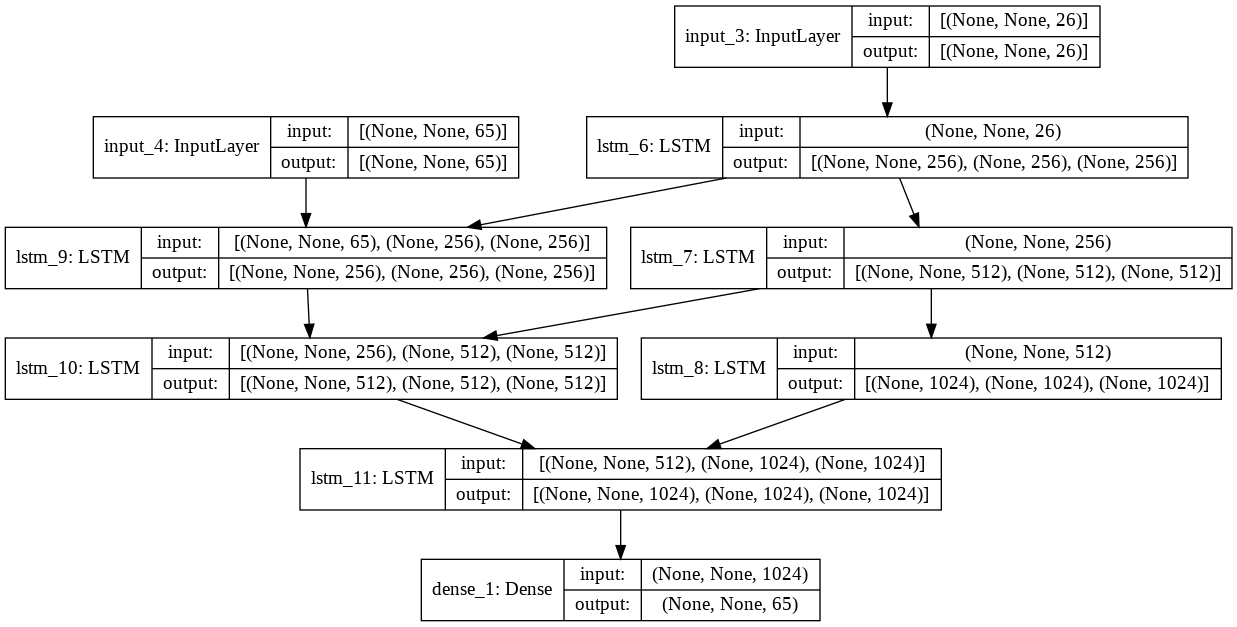

In [ ]:
plot_model(rnn.model, show_shapes=True)

**saving the model**

In [46]:
import pickle
import pathlib

with open('/content/drive/MyDrive/AS3_without_attention_best.dictionary', 'wb') as config_dictionary_file:
 
  # Step 3
  pickle.dump(rnn, config_dictionary_file)

INFO:tensorflow:Assets written to: ram://120700ec-5abd-40fa-a788-947eef307afe/assets


INFO:tensorflow:Assets written to: ram://b9569630-cb7b-4c05-96bd-adcf9415bccf/assets


INFO:tensorflow:Assets written to: ram://b9569630-cb7b-4c05-96bd-adcf9415bccf/assets


INFO:tensorflow:Assets written to: ram://d54e52a5-ae12-45f0-b6b0-656b208902c8/assets


INFO:tensorflow:Assets written to: ram://d54e52a5-ae12-45f0-b6b0-656b208902c8/assets


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Test Accuracy of the best model**

In [47]:
rnn.load_model()
test_wordAccuracy,predictions=rnn.get_predictions(test_encoder_input_data,test_target)
print(test_wordAccuracy)

0.41292758773878274


In [51]:
import csv

truth_value=[]
predicted_value =[]

with open('/content/drive/MyDrive/prediction_vanilla.csv', mode='w') as file:
  fieldnames = ['text', 'truth value', 'predicted value']
  writer = csv.DictWriter(file, fieldnames=fieldnames)
  writer.writeheader()
  for i in range(len(predictions)):
    writer.writerow({'text':test_input,"truth value":test_target,'predicted value':predictions[i]})

In [ ]:
with open('prediction_vanilla.txt','w') as f:
  f.write('predicted_word'+'\t'+'true_word\n')
  for i in range(len(predictions)):
    f.write(predictions[i]+'\t'+test_target[i])

Best model from hyperparameter tuning

In [ ]:
rnn2 = RNN_Model(3,3,256,0,0,"GRU",5)
rnn2.BUILD_MODEL(num_encoder_tokens,num_decoder_tokens)
rnn2.FIT_RNN( encoder_input_data,decoder_input_data,  decoder_target_data,10,64,
    validation_encoder_input_data,
    validation_decoder_input_data,validation_decoder_target_data)

In [ ]:
encoder_model,decoder_model= rnn2.load_model()
test_wordAccuracy,predictions=get_predictions(test_encoder_input_data,test_target_texts,encoder_model,decoder_model)
print(test_wordAccuracy)

0.35961794757885385


In [ ]:
with open('prediction_vanilla2.txt','w') as f:
  f.write('predicted_word'+'\t'+'true_word\n')
  for i in range(len(predictions)):
    f.write(predictions[i]+'\t'+test_target[i])

In [ ]:
long_index_nos= [ 843,4069,3750,535,121]
short_index_nos = [1166,1032,3151,1063,2515]

In [ ]:
  def get_prediction_word(index_nos,encoder_moder,decoder_model):
    predictions=[]
    for i in range(len(index_nos)):
      index=index_nos[i]
      input_seq = test_encoder_input_data[index:index+1]
      decoded_seq =decode_sequence_using_inference(input_seq,encoder_model,decoder_model)
      if decoded_seq[-1]=='\n':
        decoded_seq = decoded_seq[:-1]

      predictions+=[decoded_seq]
    return predictions

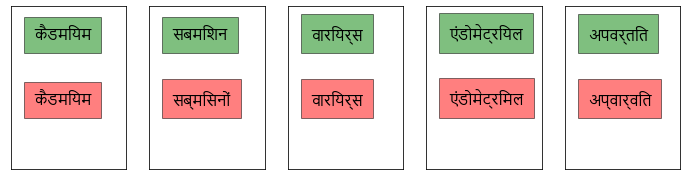

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = '/content/Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(long_index_nos),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(long_index_nos)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,long_index_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target_texts[long_index_nos[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

#plt.grid(True, which='both')

plt.show()

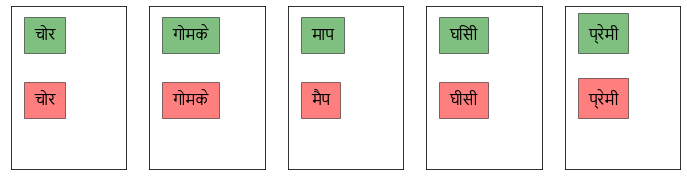

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = '/content/Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(short_index_nos),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(short_index_nos)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,short_index_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target_texts[short_index_nos[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

#plt.grid(True, which='both')

plt.show()